<a href="https://colab.research.google.com/github/kvong/DeepLearning-FingerDigitClassification/blob/master/FingerDigitDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Function to augment the data by given intensity level from 0-100
def set_augment_intensity(intensity): 
  # Specify the different transformation that can be performed on the image
  augmented_image_generator = ImageDataGenerator(
      # Commented out to perform overfitting
      rotation_range=(intensity/100)*360,
      width_shift_range=(intensity/100)*1,
      height_shift_range=(intensity/100)*1,
      shear_range=(intensity/100)*1,
      zoom_range=(intensity/100)*1,
      horizontal_flip = True,
      rescale=1./225,
      fill_mode='nearest'
  )
  return augmented_image_generator
  
# Function to automate model creation; Model from Phase 3
def init_model():
  model = models.Sequential()
  model.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(150, 150, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(32, (5, 5), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (5, 5), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(6, activation='softmax'))
  
  model.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['acc'])
  return model

def init_best_model():
  model = models.Sequential()
  model.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(150, 150, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(32, (5, 5), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (5, 5), activation='relu'))
  model.add(layers.Dropout(.25))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(6, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['acc'])
  return model

# Function to train a model on generator inputs
def train_on_generator(model, train_generator, val_generator,
                       best_model_filepath='best_model.hdf5', 
                       patience=10, 
                       steps_per_epoch=100, 
                       epochs=100, 
                       val_steps=50, 
                       verbose=2):

  # Checkpointing  
  checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=best_model_filepath, monitor='val_loss', save_best_only=True)

  # Early stop on training acc to save time
  earlystop_cb = keras.callbacks.EarlyStopping(monitor='val_acc', patience=patience)
    
  cbs = [checkpoint_cb, earlystop_cb]
  # Begin training
  history = model.fit_generator(
      train_generator, 
      steps_per_epoch=steps_per_epoch, 
      epochs=epochs, 
      callbacks=cbs,
      validation_data=val_generator, 
      validation_steps=val_steps,
      verbose=verbose
      )

  return history

# Plot learning based on history of accuracy and loss
def plot_learning_curve(history):
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.xlabel('epoch')
  plt.ylabel('Accuracy')
  plt.legend(['training accuracy', 'validation accuracy'])
  plt.title('Accuracy for each epoch')
  plt.show()
  
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.xlabel('epoch')
  plt.ylabel('Loss')
  plt.legend(['trainining loss', 'validation loss'])
  plt.title('Loss for each epoch')
  plt.show()

# Draw learning curve and evaluate model on accuracy
def get_performance(model, history, test_generator):
  plot_learning_curve(history)
  score = model.evaluate_generator(test_generator, 150)
  print('Accuracy = %.2f%%' % (score[1] * 100))
  return score[1] * 100
  
# Convert hot_encoded array to label
def hot_encoded_to_label(hot_enc):
  return np.where(hot_enc == np.amax(hot_enc))
  
# Print mismatched predictions from generator data
def generator_mismatched(model, image_generator, grid=5, image_shape=(150, 150), colorscale='gray'):
  # Displaying images from generator
  for batch in image_generator:
    images = batch[0]
    labels = batch[1]
    pred_labels = model.predict(images)
    missed = 0
    grid_count = 0
    plt.figure(figsize=(15, 15))
    plt.title('Misclassifications')
    for i in range(len(labels)):
      true_label = np.where(labels[i] == 1)
      pred_label = hot_encoded_to_label(pred_labels[i])
  
      if true_label != pred_label:
        if grid_count < grid*grid:
          plt.subplot(grid, grid, grid_count + 1)
          this_image = np.reshape(images[i], image_shape)
          xlabel = 'True: ' + str(true_label[0][0]) + ' | Pred: ' + str(pred_label[0][0])
          plt.xticks([])
          plt.yticks([])
          plt.xlabel(xlabel)
          if colorscale == 'gray':
            plt.imshow(this_image, colorscale)
          else:
            plt.imshow(this_image)
          grid_count += 1
        missed += 1
    plt.show()
    error_rate = missed/len(labels)
    print('Error rate: ', str(error_rate))
    print('Missed: ', str(missed), '/', str(len(labels)))
    break

# Show grid of images
def generator_show(image_generator, num_of_images=25, grid=5, colorscale='gray'):
  grid_count = 1
  max_reached = False
  for batch in image_generator:
    images = batch[0]
    labels = batch[1]
    plt.figure(figsize=(15, 15))
    if grid_count < num_of_images:
      for this_image in images:
        plt.subplot(grid, grid, grid_count)
        if colorscale == 'gray':
          this_image = np.reshape(this_image, (150, 150))
          plt.imshow(this_image, colorscale)
        else:
          plt.imshow(this_image)
        grid_count += 1
        if grid_count > num_of_images:
          max_reached = True;
          break
    else:
      break
    if max_reached == True:
      break

# **Phase 1: Data Preparation** 

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

 ## **Getting data file from Google Drive**

**Mounting Google Drive into Colab (use only if you have the data in your Google Drive)**

* Mount Google Drive to local drive so dataset can simply be copied over

In [0]:
root_path = 'drive/My Drive/'

In [0]:
! ls drive/My\ Drive/Finger_Digit_Data.normDist.Mask_Filter

test  train  val


In [0]:
! rm -rf Finger*
! cp -r drive/My\ Drive/FingerMask.FakeNorm.NoLeaks.zip .
! ls 

drive  FingerMask.FakeNorm.NoLeaks.zip	sample_data


In [0]:
! unzip FingerMask.FakeNorm.NoLeaks.zip
! ls -l

Archive:  FingerMask.FakeNorm.NoLeaks.zip
   creating: Finger_Digit_Data.Mask_Filter.FakeNormDist/
   creating: Finger_Digit_Data.Mask_Filter.FakeNormDist/test/
   creating: Finger_Digit_Data.Mask_Filter.FakeNormDist/test/1/
  inflating: Finger_Digit_Data.Mask_Filter.FakeNormDist/test/1/1.0.19.jpg  
  inflating: Finger_Digit_Data.Mask_Filter.FakeNormDist/test/1/1.0.3.jpg  
  inflating: Finger_Digit_Data.Mask_Filter.FakeNormDist/test/1/1.0.10.jpg  
  inflating: Finger_Digit_Data.Mask_Filter.FakeNormDist/test/1/1.0.24.jpg  
  inflating: Finger_Digit_Data.Mask_Filter.FakeNormDist/test/1/1.0.13.jpg  
  inflating: Finger_Digit_Data.Mask_Filter.FakeNormDist/test/1/1.0.9.jpg  
  inflating: Finger_Digit_Data.Mask_Filter.FakeNormDist/test/1/1.0.7.jpg  
  inflating: Finger_Digit_Data.Mask_Filter.FakeNormDist/test/1/1.0.6.jpg  
  inflating: Finger_Digit_Data.Mask_Filter.FakeNormDist/test/1/1.0.16.jpg  
  inflating: Finger_Digit_Data.Mask_Filter.FakeNormDist/test/1/1.0.22.jpg  
  inflating: Finger

In [0]:
train_data_dir  = 'Finger_Digit_Data.Mask_Filter.FakeNormDist/train/'
val_data_dir    = 'Finger_Digit_Data.Mask_Filter.FakeNormDist/val/'
test_data_dir   = 'Finger_Digit_Data.Mask_Filter.FakeNormDist/test/'

#### Upload file locally

In [0]:
from google.colab import files
files.upload()

{}

#### Using Python Image Library

In [0]:
import PIL
print('Pillow Version:', PIL.__version__)

Pillow Version: 7.0.0


In [0]:
# Open an image
from PIL import Image
image = Image.open(train_data_dir + '4/4.0.100.jpg')

In [0]:
# Looking at properties of the files
print(image.format)
print(image.mode)
print(image.size)


JPEG
L
(1200, 1200)


* Show image value as well as image itself

(1200, 1200)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


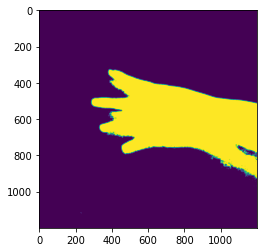

In [0]:
# Using imshow and numpy to display the image
from matplotlib.pyplot import imshow
import numpy as np

print(np.asarray(image).shape)
print(np.asarray(image))
imshow(np.asarray(image))


## **Data Generation and Augmentation**

* Creating a data pipeline for testing and validation that flow from local directory.
  * Beside rescaling, testing and validation data should not be augmented.

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale image value from [0-255] to [0, 1]
test_generator = ImageDataGenerator(rescale=1./255)

# Creating a pipeline for flow of images from local directory
test_image_generator = test_generator.flow_from_directory(
    test_data_dir, 
    target_size=(150, 150), 
    batch_size=150, 
    class_mode='categorical',
    color_mode='grayscale'
)

# Creating a pipeline for flow of images from local directory
validation_image_generator = test_generator.flow_from_directory(
    val_data_dir, 
    target_size=(150, 150), 
    batch_size=150, 
    class_mode='categorical',
    color_mode='grayscale'
)

Found 150 images belonging to 6 classes.
Found 150 images belonging to 6 classes.


* Displaying images from the pipeline in batches

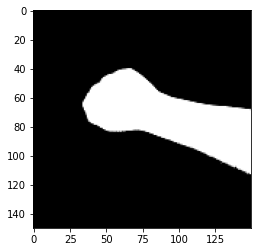

[1. 0. 0. 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Displaying images from generator
for val_batch in validation_image_generator:
  images = val_batch[0]
  labels = val_batch[1]
  for i in range(len(labels)):
    this_image = np.reshape(images[i], (150, 150))
    plt.imshow(this_image, 'gray')
    plt.show()
    print(labels[i])
    print(this_image)
    break
  break


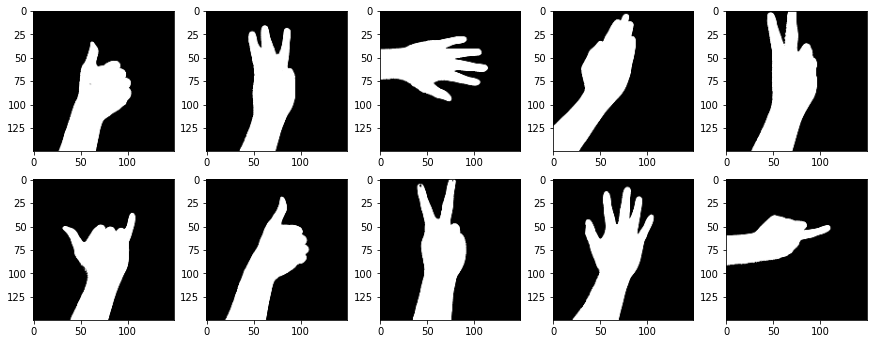

In [0]:
generator_show(test_image_generator, num_of_images=10)

**Generate Augmented data from the pipeline**

* Create the pipeline from the data directory.
  * If we don't have enough training samples, we can augment the image to create more training data.

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify the different transformation that can be performed on the image
augmented_image_generator = ImageDataGenerator(
    # Commented out to perform overfitting
    rotation_range=40,
    width_shift_range=.15,
    height_shift_range=.15,
    shear_range=.15,
    zoom_range=.15,
    horizontal_flip = True,
    rescale=1./225,
    fill_mode='nearest'
    
)

In [0]:
# Create training pipeline
training_image_generator = augmented_image_generator.flow_from_directory(
    train_data_dir, 
    target_size=(150,150), 
    batch_size=150, 
    class_mode='categorical',
    color_mode='grayscale'
)

Found 1500 images belonging to 6 classes.


In [0]:
import numpy as np
import matplotlib.pyplot as plt

for training_batch in training_image_generator:
  images = training_batch[0]
  labels = training_batch[1]
  for i in range(len(labels)):
    this_image = np.reshape(images[i], (150, 150))
    plt.imshow(this_image, 'gray')
    plt.show()
    print(labels[i])
  break

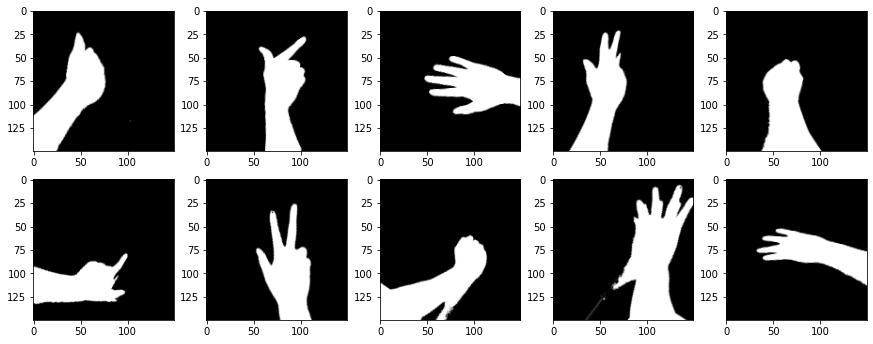

In [0]:
generator_show(training_image_generator, 10)

## Data visualization

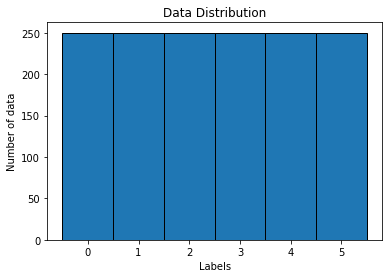

All possible classes [0, 1, 2, 3, 4, 5]
Base accuracy score = 16.67%


In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the distribution of all classes manually
my_classes = training_image_generator.classes
all_classes = [my_classes[0]]
current_class = my_classes[0]
highest_class_sample = 0
temp_class_sample = 1
for this_class in my_classes:
  if current_class != this_class:
    current_class = this_class
    all_classes.append(current_class)
    temp_class_sample = 0 

  if temp_class_sample > highest_class_sample:
    highest_class_sample = temp_class_sample
  temp_class_sample += 1

# Displaying data distribution
plt.hist(x=my_classes, bins=np.arange(len(all_classes) + 1) - .5, ec='k')
plt.title('Data Distribution')
plt.xlabel('Labels')
plt.ylabel('Number of data')
plt.show()

#print('All y values', my_classes)
print('All possible classes', all_classes)
print('Base accuracy score = %.2f%%' % float(highest_class_sample/len(my_classes) * 100))


# **Phase 2: Build An Overfitting Model**
* Attempt to get 100% accuracy by training only with the training data.

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify the different transformation that can be performed on the image
image_generator = ImageDataGenerator(rescale=1./255)

# Creating a pipeline for flow of images from local directory
training_image_generator = image_generator.flow_from_directory(
    test_data_dir, 
    target_size=(150, 150), 
    batch_size=150, 
    class_mode='categorical',
    color_mode='grayscale'
)


Found 150 images belonging to 6 classes.


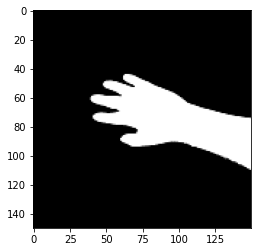

[0. 0. 0. 0. 0. 1.]


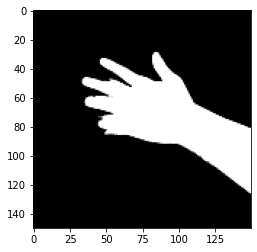

[0. 0. 0. 0. 0. 1.]


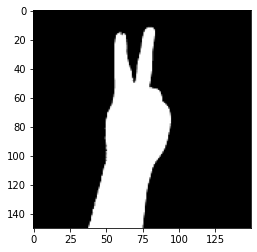

[0. 0. 1. 0. 0. 0.]


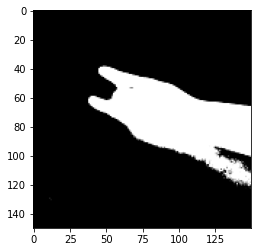

[0. 0. 1. 0. 0. 0.]


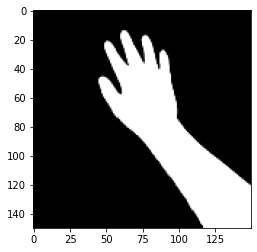

[0. 0. 0. 0. 0. 1.]


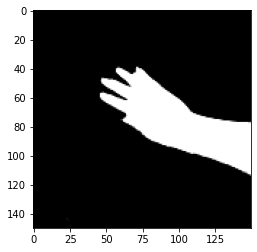

[0. 0. 0. 0. 1. 0.]


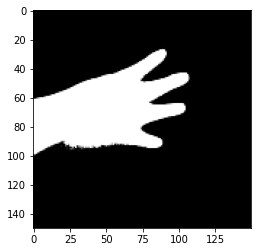

[0. 0. 0. 0. 1. 0.]


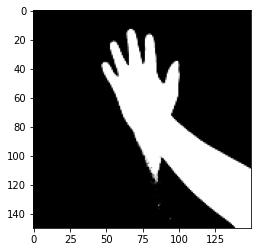

[0. 0. 0. 0. 0. 1.]


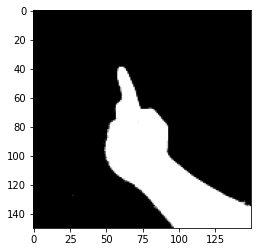

[0. 1. 0. 0. 0. 0.]


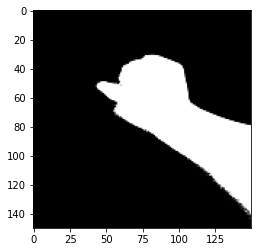

[0. 1. 0. 0. 0. 0.]


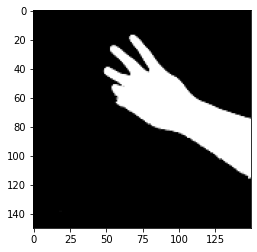

[0. 0. 0. 0. 1. 0.]


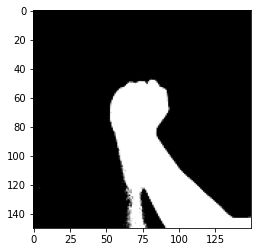

[1. 0. 0. 0. 0. 0.]


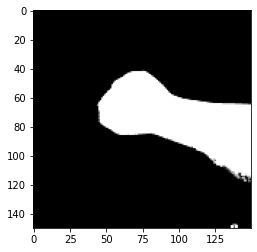

[1. 0. 0. 0. 0. 0.]


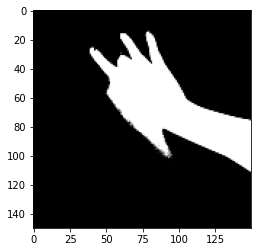

[0. 0. 0. 1. 0. 0.]


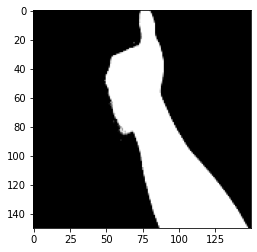

[0. 1. 0. 0. 0. 0.]


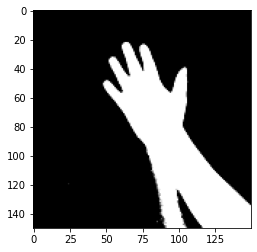

[0. 0. 0. 0. 0. 1.]


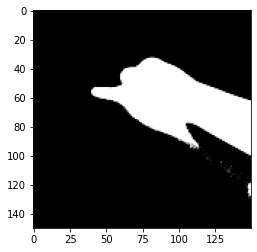

[0. 1. 0. 0. 0. 0.]


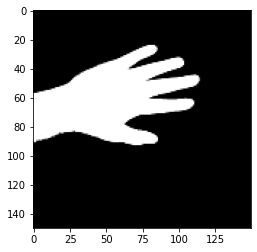

[0. 0. 0. 0. 0. 1.]


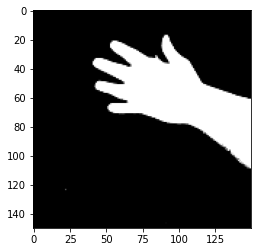

[0. 0. 0. 0. 0. 1.]


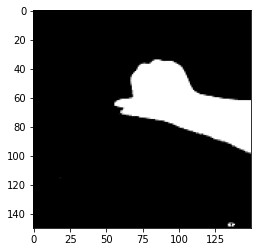

[0. 1. 0. 0. 0. 0.]


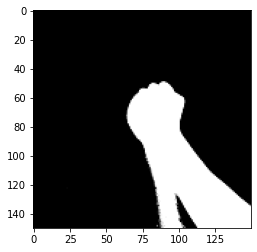

[1. 0. 0. 0. 0. 0.]


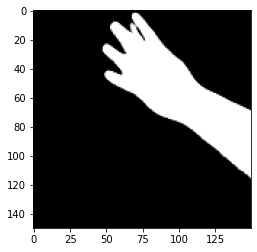

[0. 0. 0. 0. 1. 0.]


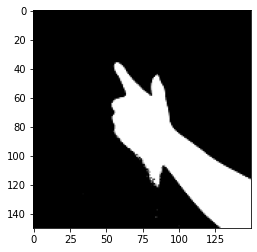

[0. 0. 1. 0. 0. 0.]


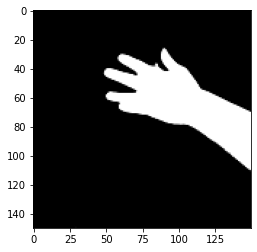

[0. 0. 0. 0. 0. 1.]


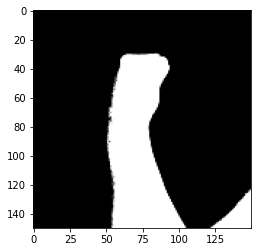

[1. 0. 0. 0. 0. 0.]


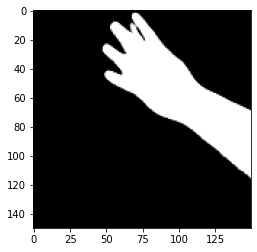

[0. 0. 0. 0. 1. 0.]


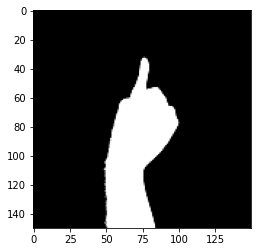

[0. 1. 0. 0. 0. 0.]


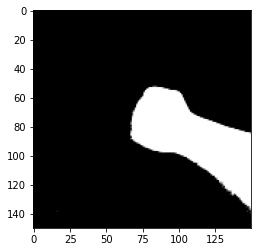

[1. 0. 0. 0. 0. 0.]


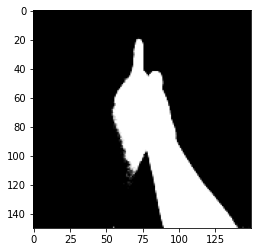

[0. 1. 0. 0. 0. 0.]


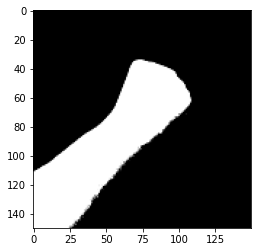

[1. 0. 0. 0. 0. 0.]


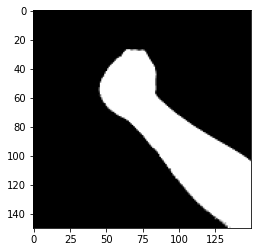

[1. 0. 0. 0. 0. 0.]


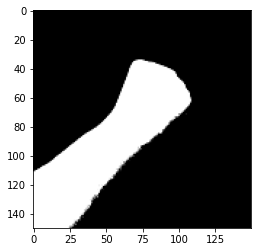

[1. 0. 0. 0. 0. 0.]


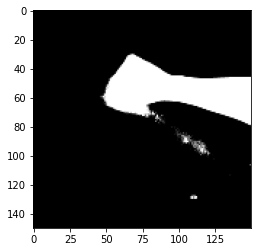

[1. 0. 0. 0. 0. 0.]


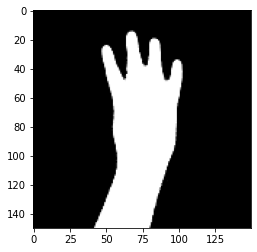

[0. 0. 0. 0. 1. 0.]


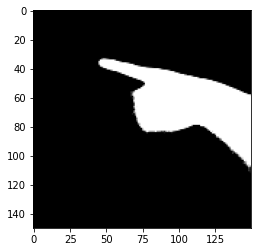

[0. 1. 0. 0. 0. 0.]


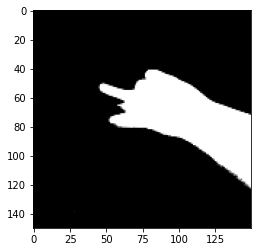

[0. 0. 1. 0. 0. 0.]


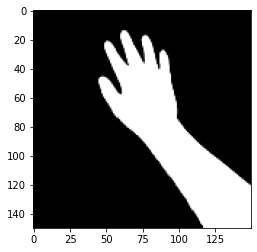

[0. 0. 0. 0. 0. 1.]


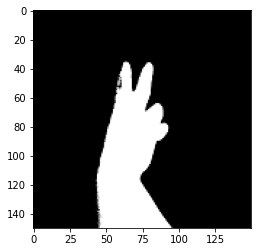

[0. 0. 1. 0. 0. 0.]


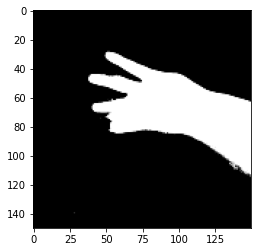

[0. 0. 0. 0. 1. 0.]


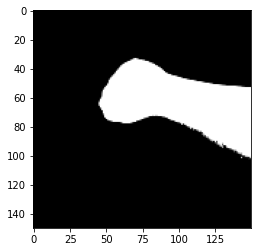

[1. 0. 0. 0. 0. 0.]


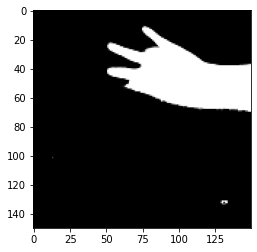

[0. 0. 0. 1. 0. 0.]


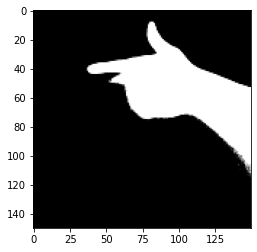

[0. 0. 1. 0. 0. 0.]


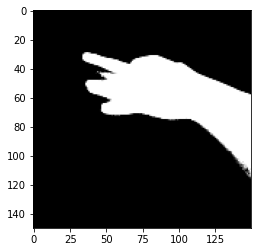

[0. 0. 0. 1. 0. 0.]


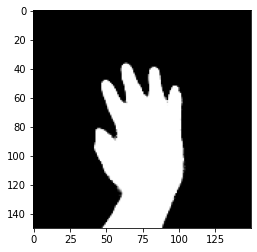

[0. 0. 0. 0. 0. 1.]


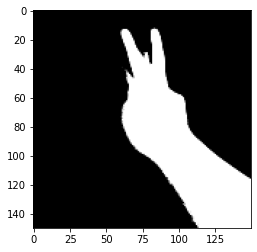

[0. 0. 1. 0. 0. 0.]


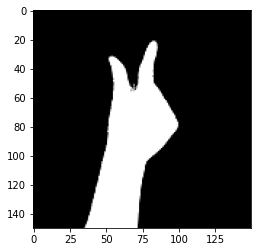

[0. 0. 1. 0. 0. 0.]


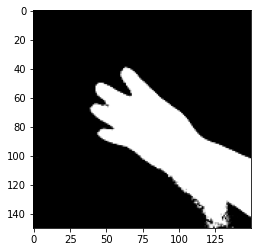

[0. 0. 0. 0. 1. 0.]


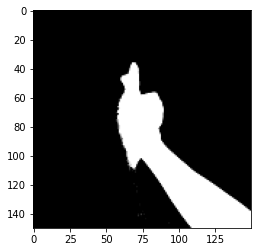

[0. 0. 1. 0. 0. 0.]


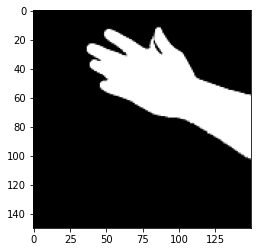

[0. 0. 0. 0. 0. 1.]


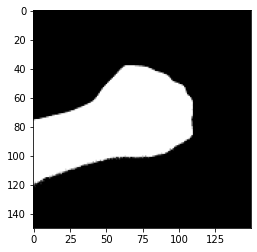

[1. 0. 0. 0. 0. 0.]


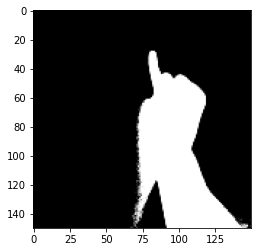

[0. 1. 0. 0. 0. 0.]


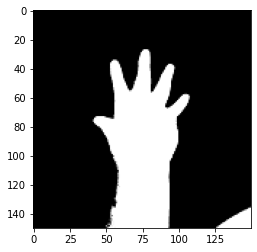

[0. 0. 0. 0. 0. 1.]


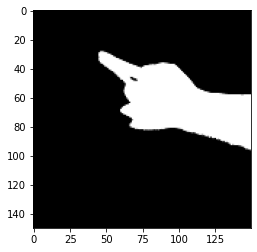

[0. 0. 1. 0. 0. 0.]


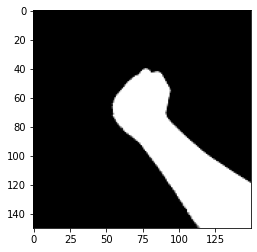

[1. 0. 0. 0. 0. 0.]


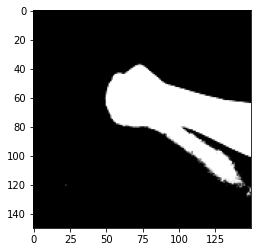

[1. 0. 0. 0. 0. 0.]


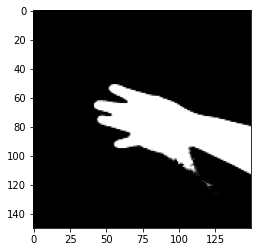

[0. 0. 0. 0. 1. 0.]


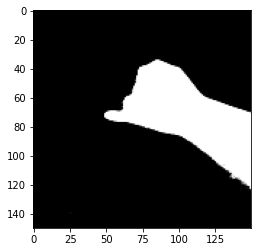

[0. 1. 0. 0. 0. 0.]


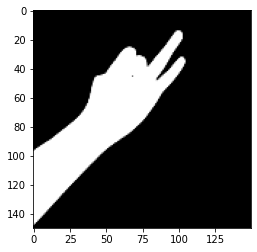

[0. 0. 1. 0. 0. 0.]


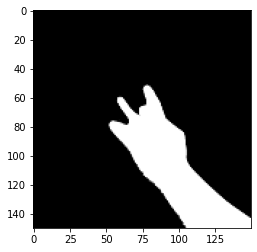

[0. 0. 0. 1. 0. 0.]


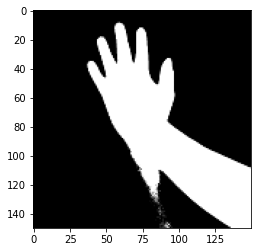

[0. 0. 0. 0. 0. 1.]


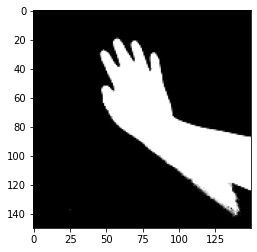

[0. 0. 0. 0. 0. 1.]


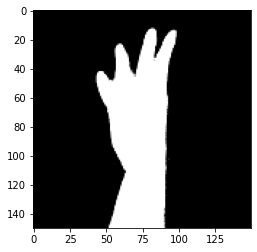

[0. 0. 0. 0. 1. 0.]


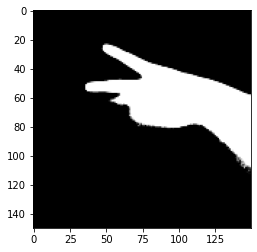

[0. 0. 1. 0. 0. 0.]


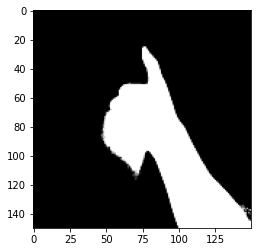

[0. 1. 0. 0. 0. 0.]


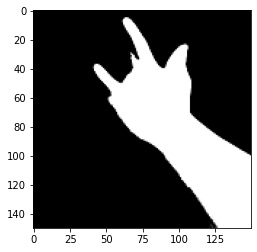

[0. 0. 0. 1. 0. 0.]


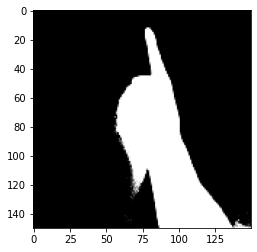

[0. 1. 0. 0. 0. 0.]


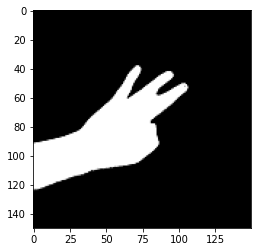

[0. 0. 0. 1. 0. 0.]


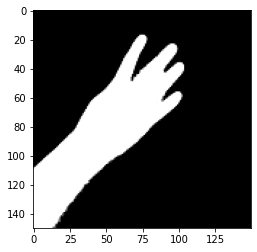

[0. 0. 0. 0. 1. 0.]


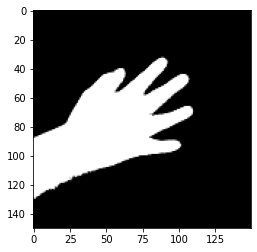

[0. 0. 0. 0. 0. 1.]


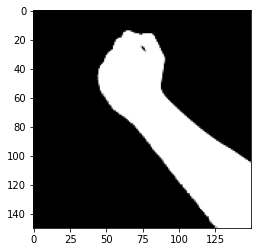

[1. 0. 0. 0. 0. 0.]


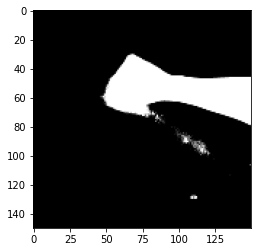

[1. 0. 0. 0. 0. 0.]


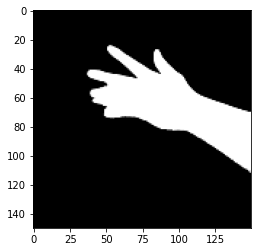

[0. 0. 0. 0. 0. 1.]


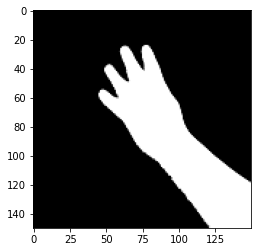

[0. 0. 0. 0. 1. 0.]


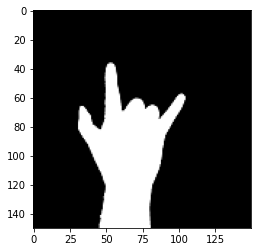

[0. 0. 0. 1. 0. 0.]


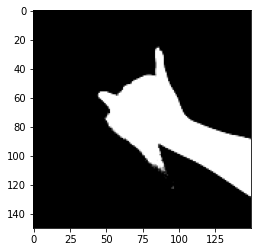

[0. 0. 1. 0. 0. 0.]


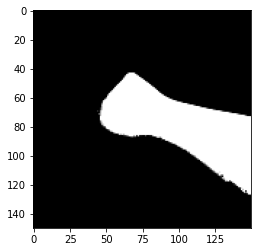

[1. 0. 0. 0. 0. 0.]


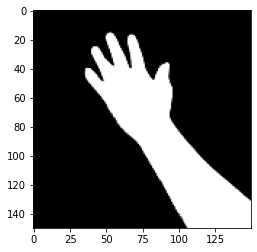

[0. 0. 0. 0. 0. 1.]


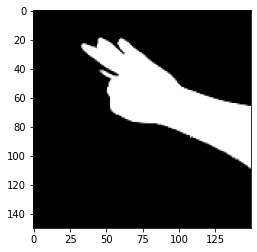

[0. 0. 0. 1. 0. 0.]


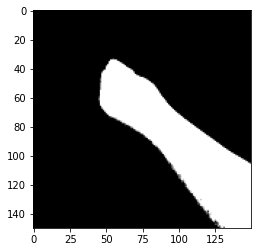

[1. 0. 0. 0. 0. 0.]


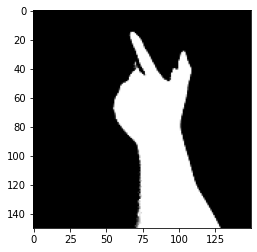

[0. 0. 1. 0. 0. 0.]


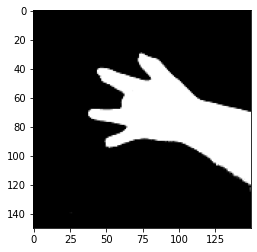

[0. 0. 0. 0. 1. 0.]


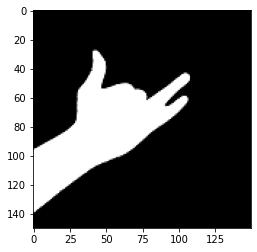

[0. 0. 0. 1. 0. 0.]


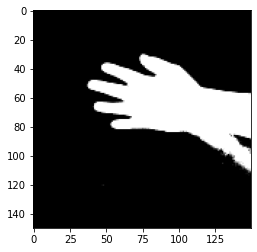

[0. 0. 0. 0. 0. 1.]


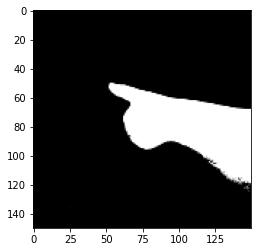

[0. 1. 0. 0. 0. 0.]


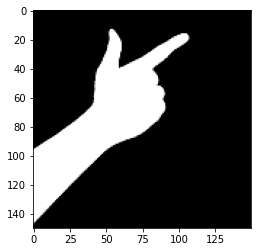

[0. 0. 1. 0. 0. 0.]


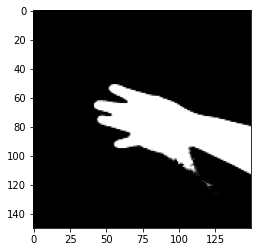

[0. 0. 0. 0. 1. 0.]


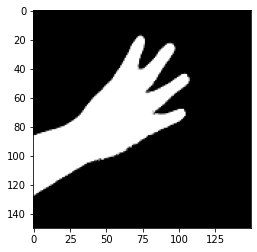

[0. 0. 0. 0. 1. 0.]


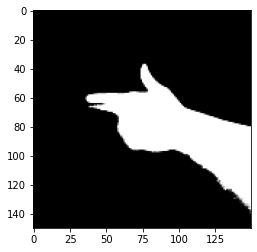

[0. 0. 1. 0. 0. 0.]


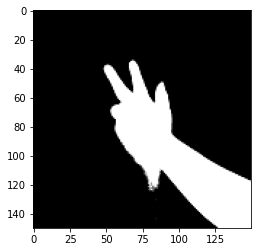

[0. 0. 0. 1. 0. 0.]


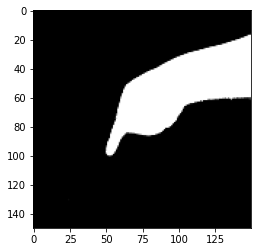

[0. 1. 0. 0. 0. 0.]


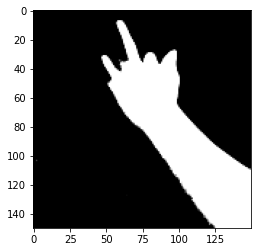

[0. 0. 0. 1. 0. 0.]


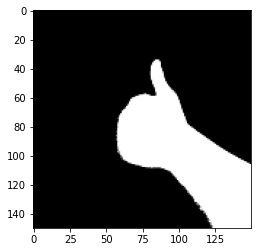

[0. 1. 0. 0. 0. 0.]


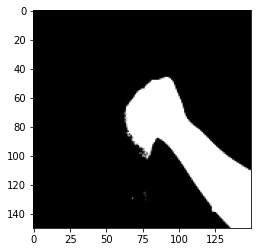

[1. 0. 0. 0. 0. 0.]


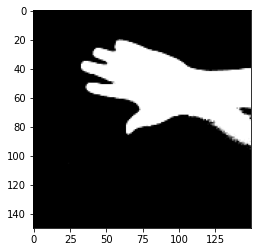

[0. 0. 0. 0. 0. 1.]


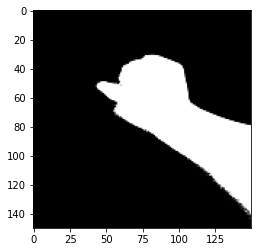

[0. 1. 0. 0. 0. 0.]


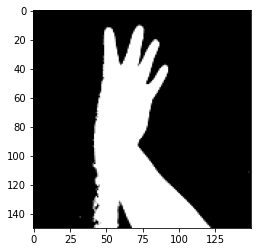

[0. 0. 0. 0. 1. 0.]


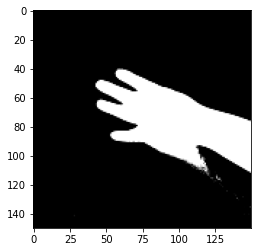

[0. 0. 0. 0. 1. 0.]


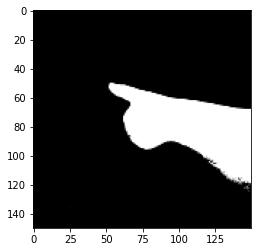

[0. 1. 0. 0. 0. 0.]


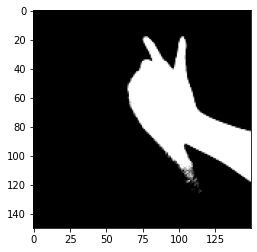

[0. 0. 1. 0. 0. 0.]


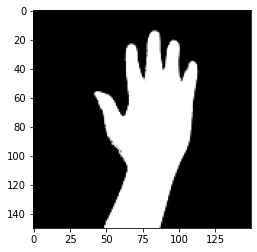

[0. 0. 0. 0. 0. 1.]


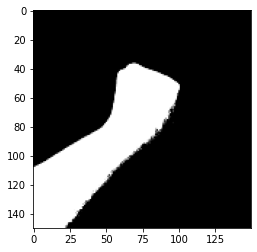

[1. 0. 0. 0. 0. 0.]


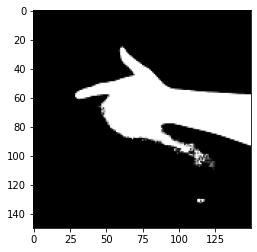

[0. 0. 1. 0. 0. 0.]


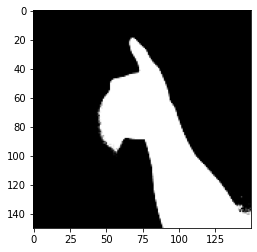

[0. 1. 0. 0. 0. 0.]


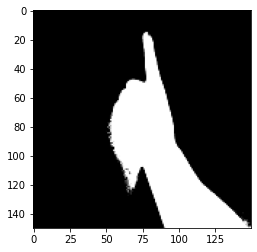

[0. 1. 0. 0. 0. 0.]


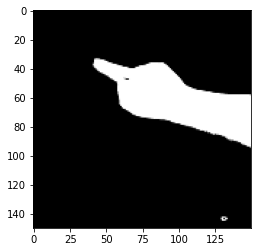

[0. 1. 0. 0. 0. 0.]


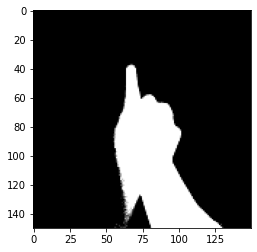

[0. 1. 0. 0. 0. 0.]


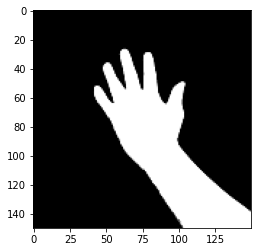

[0. 0. 0. 0. 0. 1.]


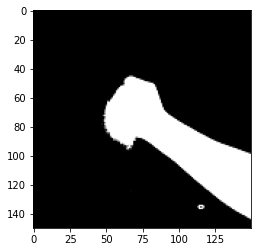

[1. 0. 0. 0. 0. 0.]


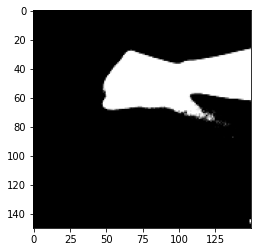

[1. 0. 0. 0. 0. 0.]


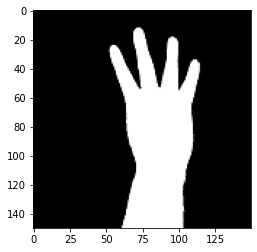

[0. 0. 0. 0. 1. 0.]


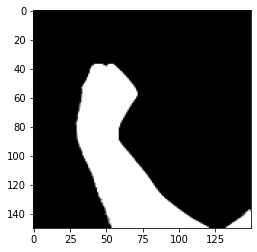

[1. 0. 0. 0. 0. 0.]


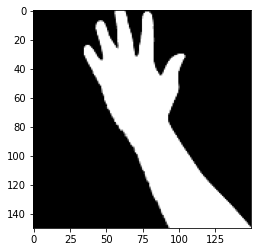

[0. 0. 0. 0. 0. 1.]


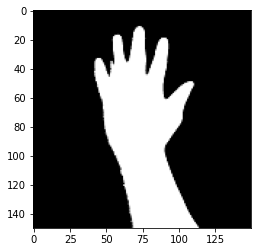

[0. 0. 0. 0. 0. 1.]


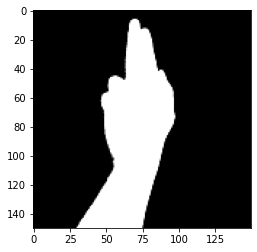

[0. 0. 0. 1. 0. 0.]


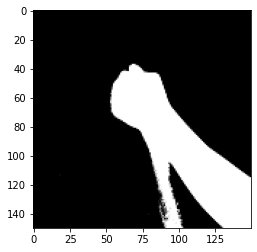

[1. 0. 0. 0. 0. 0.]


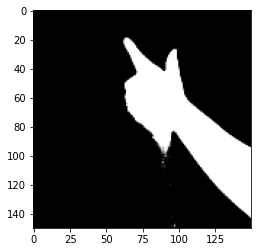

[0. 0. 1. 0. 0. 0.]


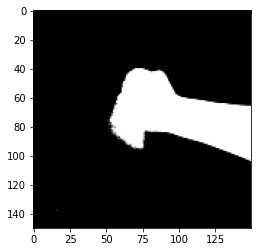

[1. 0. 0. 0. 0. 0.]


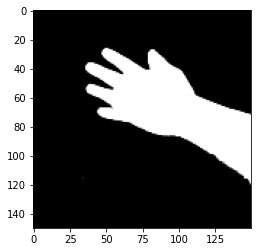

[0. 0. 0. 0. 0. 1.]


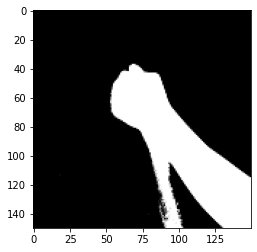

[1. 0. 0. 0. 0. 0.]


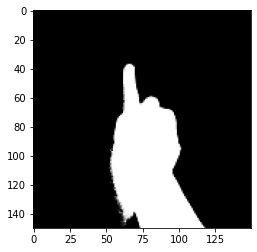

[0. 1. 0. 0. 0. 0.]


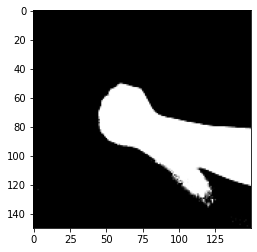

[1. 0. 0. 0. 0. 0.]


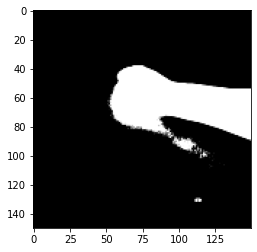

[1. 0. 0. 0. 0. 0.]


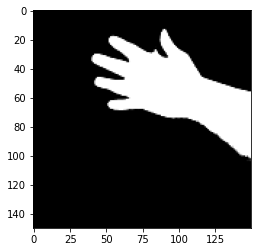

[0. 0. 0. 0. 0. 1.]


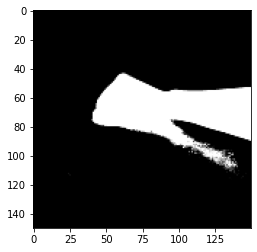

[1. 0. 0. 0. 0. 0.]


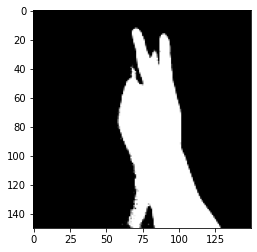

[0. 0. 1. 0. 0. 0.]


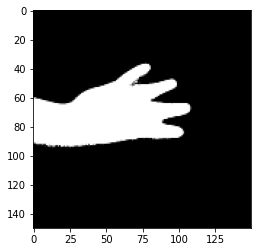

[0. 0. 0. 0. 1. 0.]


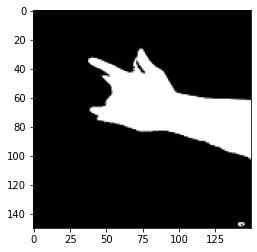

[0. 0. 0. 1. 0. 0.]


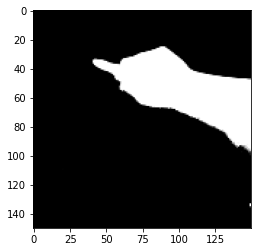

[0. 1. 0. 0. 0. 0.]


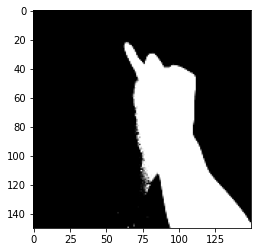

[0. 1. 0. 0. 0. 0.]


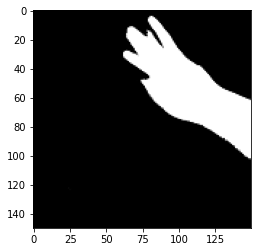

[0. 0. 0. 1. 0. 0.]


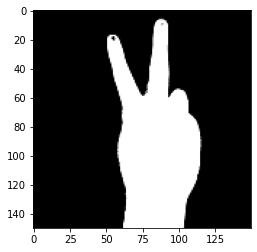

[0. 0. 1. 0. 0. 0.]


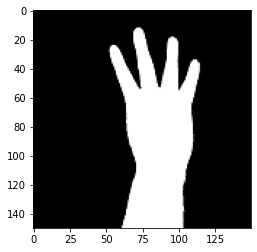

[0. 0. 0. 0. 1. 0.]


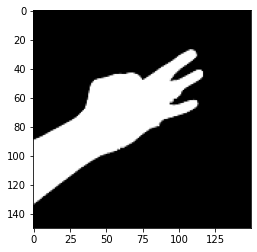

[0. 0. 0. 1. 0. 0.]


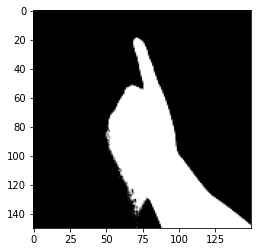

[0. 1. 0. 0. 0. 0.]


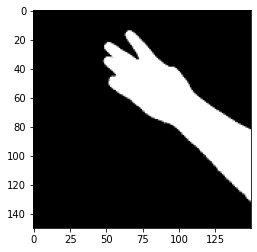

[0. 0. 0. 0. 1. 0.]


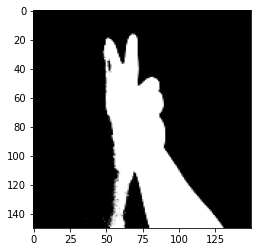

[0. 0. 1. 0. 0. 0.]


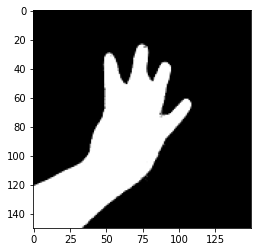

[0. 0. 0. 0. 1. 0.]


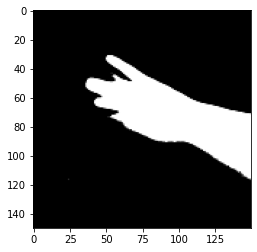

[0. 0. 0. 1. 0. 0.]


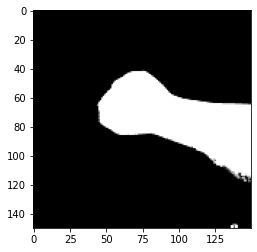

[1. 0. 0. 0. 0. 0.]


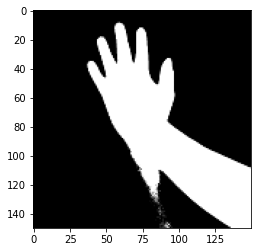

[0. 0. 0. 0. 0. 1.]


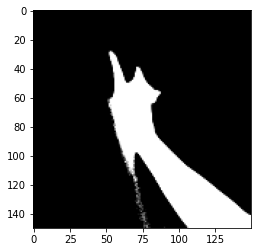

[0. 1. 0. 0. 0. 0.]


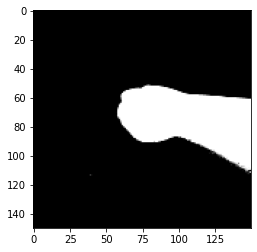

[1. 0. 0. 0. 0. 0.]


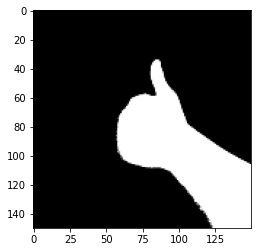

[0. 1. 0. 0. 0. 0.]


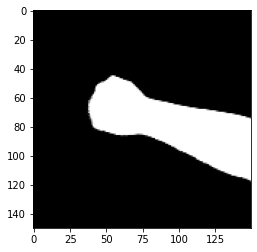

[1. 0. 0. 0. 0. 0.]


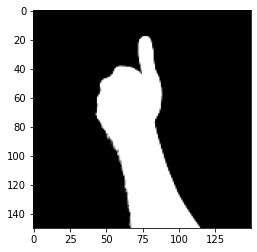

[0. 1. 0. 0. 0. 0.]


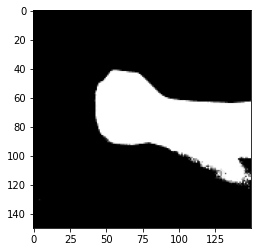

[1. 0. 0. 0. 0. 0.]


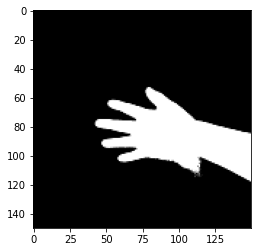

[0. 0. 0. 0. 0. 1.]


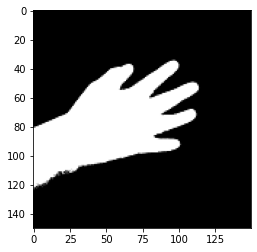

[0. 0. 0. 0. 0. 1.]


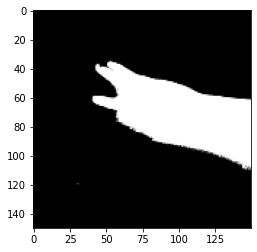

[0. 0. 0. 1. 0. 0.]


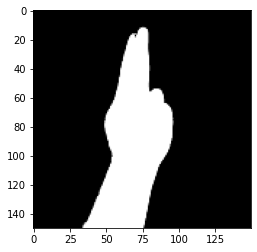

[0. 0. 1. 0. 0. 0.]


In [0]:
import numpy as np
import matplotlib.pyplot as plt

for training_batch in training_image_generator:
  images = training_batch[0]
  labels = training_batch[1]
  for i in range(len(labels)):
    this_image = np.reshape(images[i], (150, 150))
    plt.imshow(this_image, 'gray')
    plt.show()
    print(labels[i])
  break

## Building a Many Layered Network

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import models

model_overfit = models.Sequential()
model_overfit.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(150, 150, 1)))
model_overfit.add(layers.MaxPooling2D((2, 2)))
model_overfit.add(layers.Conv2D(32, (5, 5), activation='relu'))
model_overfit.add(layers.MaxPooling2D((2, 2)))
model_overfit.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_overfit.add(layers.MaxPooling2D((2, 2)))
model_overfit.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_overfit.add(layers.MaxPooling2D((2, 2)))
model_overfit.add(layers.Flatten())
model_overfit.add(layers.Dense(128, activation='relu'))
model_overfit.add(layers.Dense(64, activation='relu'))
model_overfit.add(layers.Dense(6, activation='softmax'))
model_overfit.summary()

model_overfit.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 146, 146, 16)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 69, 69, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        1

In [0]:
from tensorflow import keras

# Checkpointing  
#checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=root_path + 'manylayer_overfit.hdf5', monitor='loss', save_best_only=True)
# Early stop on training acc to save time
earlystop_cb = keras.callbacks.EarlyStopping(monitor='acc', patience=10)
  
#cbs = [checkpoint_cb, earlystop_cb]

# Begin training
history_1 = model_overfit.fit_generator(
    training_image_generator, 
    steps_per_epoch=100, 
    epochs=100, 
    verbose=2,
    callbacks=[earlystop_cb]
    )


Epoch 1/100
100/100 - 53s - loss: 0.2874 - acc: 0.9103
Epoch 2/100
100/100 - 53s - loss: 3.6984e-05 - acc: 1.0000
Epoch 3/100
100/100 - 52s - loss: 7.6381e-08 - acc: 1.0000
Epoch 4/100
100/100 - 52s - loss: 1.9153e-09 - acc: 1.0000
Epoch 5/100
100/100 - 52s - loss: 0.6082 - acc: 0.9828
Epoch 6/100
100/100 - 52s - loss: 9.8525e-04 - acc: 1.0000
Epoch 7/100
100/100 - 52s - loss: 1.7105e-06 - acc: 1.0000
Epoch 8/100
100/100 - 52s - loss: 5.6982e-09 - acc: 1.0000
Epoch 9/100
100/100 - 51s - loss: 0.0000e+00 - acc: 1.0000
Epoch 10/100
100/100 - 51s - loss: 0.0000e+00 - acc: 1.0000
Epoch 11/100
100/100 - 51s - loss: 0.0000e+00 - acc: 1.0000
Epoch 12/100
100/100 - 51s - loss: 0.0000e+00 - acc: 1.0000


In [0]:
# Save model
model_overfit.save(root_path + 'manylayer_overfit.h5')

In [0]:
print(history_1.params)

{'verbose': 2, 'epochs': 100, 'steps': 10}



### **Learning Curve**

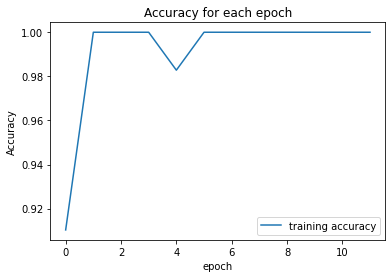

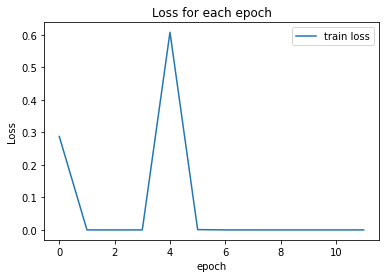

In [0]:
import matplotlib.pyplot as plt

plt.plot(history_1.history['acc'])
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['training accuracy'])
plt.title('Accuracy for each epoch')
plt.show()

plt.plot(history_1.history['loss'])
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['train loss'])
plt.title('Loss for each epoch')
plt.show()

In [0]:
# Load existing model
model_overfit.load_model(root_path + 'manylayer_overfit.h5')

## **Training vs Testing performance**
* Show that the model does very well on the training set.

In [0]:
score = model_overfit.evaluate_generator(training_image_generator, 1)
print('Accuracy on training set = %.2f%%' % (score[1] * 100))
score = model_overfit.evaluate_generator(validation_image_generator, 1)
print('Accuracy on validation set = %.2f%%' % (score[1] * 100))


Instructions for updating:
Please use Model.evaluate, which supports generators.
Accuracy on training set = 100.00%
Accuracy on validation set = 34.67%


## **Another Way to Overfit The Model**
* Adding output in our input.
  * The original image of (150, 150, **1**) becomes (150, 150, **2**), where the final layer contain the output.

In [0]:
# Adding output into the input
from tensorflow.keras import layers
from tensorflow.keras import models
import numpy as np

# Empty placeholders for 1500 RGB images and their labels
mydatax = np.zeros((1500, 150, 150, 1))
mydatay = np.zeros((1500, 150, 150,1))

# Create a array of 1D array to store all y values
mydatay_hotenc = np.zeros((1500, 6))

# Where to merge mydatax and mydatay
mydata = np.zeros((1500, 150, 150, 2))

# Array of scalar to store true value, not hot_encoded
mydatay_true = np.zeros((1500))

# Read everything from your generator
data_count = 0
for x, y in training_image_generator:
  for j in range(len(x)):
    mydatax[data_count] = x[j]

    # Get true label 1 is true, 0 is false
    class_index = list(y[j]).index(1)
    mydatay[data_count] += class_index

    mydatay_hotenc[data_count][class_index - 1] += 1

    mydatay_true[data_count] = class_index

    # Merge mydatax and mydatay together
    mydata[data_count] += mydatax[data_count]
    mydata[data_count, :, :, 1] = np.reshape(mydatay[data_count], (150, 150))

    data_count += 1
  if data_count >= 1500:
    break

# Same as above but with validation generator
myvalx = np.zeros((150, 150, 150, 2))
myvalx1 = np.zeros((150, 150, 150, 1))
myvalx2 = np.zeros((150, 150, 150, 1))
myvaly = np.zeros((150, 6))
data_count = 0
for x, y in validation_image_generator:
  for j in range(len(x)):
    myvalx1[data_count] = x[j]

    # Get true label 1 is true, 0 is false
    class_index = list(y[j]).index(1)
    myvalx2 += class_index

    # hot-encode y
    myvaly[data_count][class_index - 1] += 1

    # Merge valx1 and valx2
    myvalx[data_count] += myvalx1[data_count]
    myvalx[data_count, :, :, 1] = np.reshape(myvalx2[data_count], (150, 150))

    data_count += 1
  if data_count >= 150:
    break


Newly added layer
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1500, 150, 150, 2)


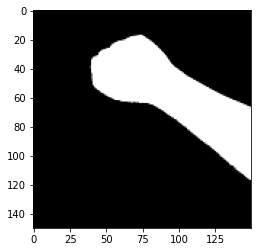

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Inspect the data
for i, image in enumerate(mydata):
  # Look at the label layer
  print('Newly added layer')
  print(mydata[i, :, :, 1])
  print(mydata.shape)

  # Look at the image itself
  this_image = np.reshape(image[:, :, 0], (150, 150))
  plt.imshow(this_image, 'gray')
  plt.show()
  break

### **How quickly can we overfit?**
* This time using less layers and filters

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import models

model_overfit_1 = models.Sequential()
model_overfit_1.add(layers.Conv2D(6, (5, 5), activation='relu', input_shape=(150, 150, 2)))
model_overfit_1.add(layers.MaxPooling2D((2, 2)))
model_overfit_1.add(layers.Flatten())
model_overfit_1.add(layers.Dense(128, activation='relu'))
model_overfit_1.add(layers.Dense(6, activation='softmax'))
model_overfit_1.summary()

model_overfit_1.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['acc'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 146, 146, 6)       306       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 73, 73, 6)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 31974)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               4092800   
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 774       
Total params: 4,093,880
Trainable params: 4,093,880
Non-trainable params: 0
_________________________________________________________________


In [0]:
from tensorflow import keras

# Early stop on training acc to save time
call_back = keras.callbacks.EarlyStopping( monitor = 'acc', patience =10)

# Begin training
history = model_overfit_1.fit(
    x=mydata,
    y=mydatay_hotenc,
    batch_size=100, 
    epochs=50, 
    callbacks=[call_back]
    )

Epoch 1/50
15/15 [==============================] - 1s 37ms/step - loss: 11.6644 - acc: 0.5447
Epoch 2/50
15/15 [==============================] - 0s 31ms/step - loss: 0.7029 - acc: 0.7407
Epoch 3/50
15/15 [==============================] - 0s 30ms/step - loss: 0.5153 - acc: 0.8187
Epoch 4/50
15/15 [==============================] - 0s 30ms/step - loss: 0.5303 - acc: 0.8220
Epoch 5/50
15/15 [==============================] - 0s 30ms/step - loss: 0.1643 - acc: 0.9380
Epoch 6/50
15/15 [==============================] - 0s 30ms/step - loss: 0.6234 - acc: 0.8767
Epoch 7/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0370 - acc: 0.9973
Epoch 8/50
15/15 [==============================] - 0s 30ms/step - loss: 0.9038 - acc: 0.8447
Epoch 9/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0423 - acc: 0.9973
Epoch 10/50
15/15 [==============================] - 0s 30ms/step - loss: 0.0098 - acc: 1.0000
Epoch 11/50
15/15 [==============================] - 0s 30

In [0]:
# Save model
model_overfit_1.save(root_path + 'OutAsIn_overfit.h5')

In [0]:
# Load existing model
model_overfit_1.load_model(root_path + 'OutAsIn_overfit.h5')

In [0]:
print(history.params)

{'batch_size': 100, 'epochs': 50, 'steps': None, 'samples': 1500, 'verbose': 1, 'do_validation': False, 'metrics': ['loss', 'acc']}


In [0]:
score = model_overfit_1.evaluate(mydata, mydatay_hotenc)
print('Accuracy on training set = %.2f%%' % (score[1] * 100))
score = model_overfit_1.evaluate(mytestx, myvaly)
print('Accuracy on test set = %.2f%%' % (score[1] * 100))

47/47 [==============================] - 0s 9ms/step - loss: 3.4058e-04 - acc: 1.0000
Accuracy on training set = 100.00%
5/5 [==============================] - 0s 6ms/step - loss: 1215.2825 - acc: 0.1667
Accuracy on test set = 16.67%


### **Learning Curve**

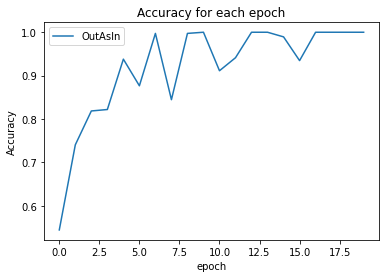

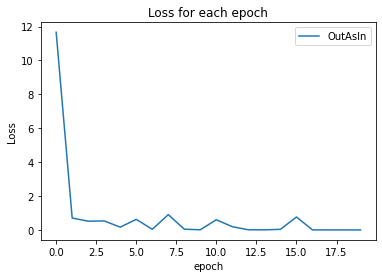

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['OutAsIn'])
plt.title('Accuracy for each epoch')
plt.show()

plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['OutAsIn'])
plt.title('Loss for each epoch')
plt.show()

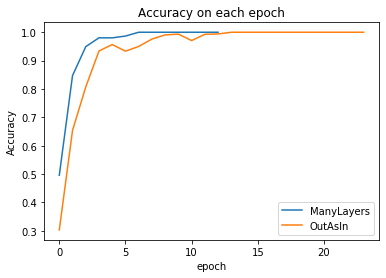

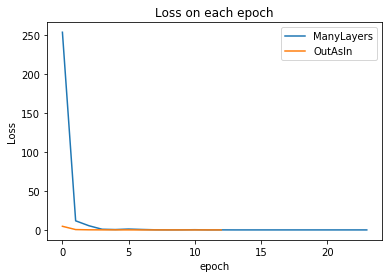

In [0]:
import matplotlib.pyplot as plt

plt.plot(history_1.history['acc'])
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['ManyLayers', 'OutAsIn'])
plt.title('Accuracy on each epoch')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history_1.history['loss'])
#plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['ManyLayers', 'OutAsIn'])
plt.title('Loss on each epoch')
plt.show()

# **Phase 3: Split And Evaluate On Test Set**

* Because we have already split the data in Phase1, here we will simply train our model and evaluate on the test set.

## **Create and train multiple models**
- Have multiple models train over the same data and observe their performance on the test set.

### Model 1

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 146, 146, 16)      416       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 69, 69, 32)        12832     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36992)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2367552   
_________________________________________________________________
dense_4 (Dense)              (None, 6)                

In [0]:
# Train using training function
training_history_1 = train_on_generator(
    model=model, train_generator=training_image_generator,
    val_generator=validation_image_generator, 
    best_model_filepath=root_path + 'bestmodel1.hdf5')

In [0]:
# Save model
model.save_weights(root_path + 'model_1.hdf5')

In [0]:
# Load model
model.load_weights(root_path + 'model_1.hdf5')

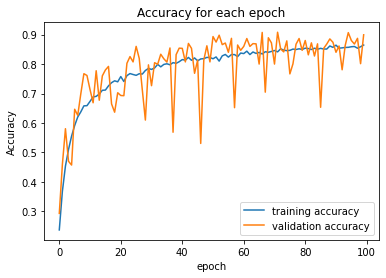

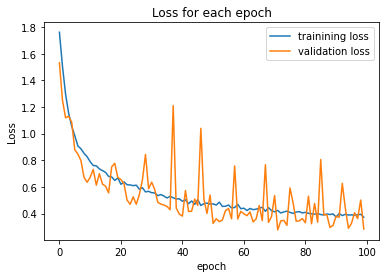

In [0]:
plot_learning_curve(training_history)

In [0]:
score = model.evaluate_generator(validation_image_generator, 150)
print('Accuracy on test set = %.2f%%' % (score[1] * 100))

Accuracy on test set = 90.62%


### Model 2

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['acc'])

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 146, 146, 16)      416       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 69, 69, 32)        12832     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 30, 30, 64)        51264     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 14400)           

In [0]:
training_history_2 = train_on_generator(model=model, train_generator=training_image_generator, val_generator=validation_image_generator)

In [0]:
# Save model
model.save_weights(root_path + 'model_2.hdf5')

In [0]:
# Load model
model.load_weights(root_path + 'model_2.hdf5')

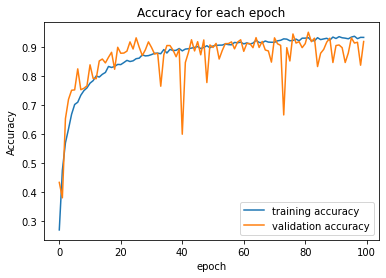

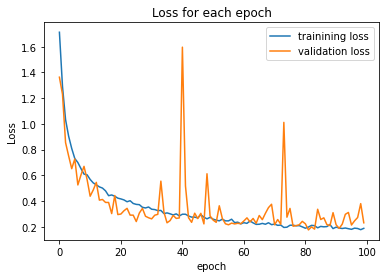

In [0]:
plot_learning_curve(training_history_2)

In [0]:
score = model.evaluate_generator(test_image_generator, 150)
print('Accuracy on test set = %.2f%%' % (score[1] * 100))

Accuracy on test set = 89.96%


### Model 3

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 146, 146, 16)      416       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 69, 32)        12832     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36992)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               4735104   
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [0]:
training_history_3 = train_on_generator(model=model, train_generator=training_image_generator, val_generator=validation_image_generator)

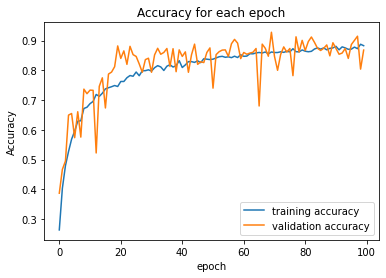

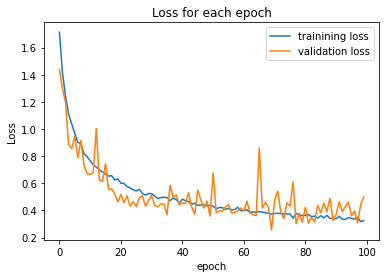

In [0]:
plot_learning_curve(training_history_3)

In [0]:
# Save model
model.save_weights(root_path + 'model_3.hdf5')

In [0]:
# Load model
model.load_weights(root_path + 'model_3.hdf5')

In [0]:
score = model.evaluate_generator(test_image_generator, 150)
print('Accuracy on test set = %.2f%%' % (score[1] * 100))

Instructions for updating:
Please use Model.evaluate, which supports generators.
Accuracy on test set = 87.33%


### Model 4
Increase both Convolutional and Dense layers

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 146, 146, 16)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 69, 69, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0

In [0]:
training_history_4 = train_on_generator(model=model, train_generator=training_image_generator, val_generator=validation_image_generator)

In [0]:
# Save model
model.save_weights(root_path + 'model_4.hdf5')

In [0]:
# Load model
model.load_weights(root_path + 'model_4.hdf5')

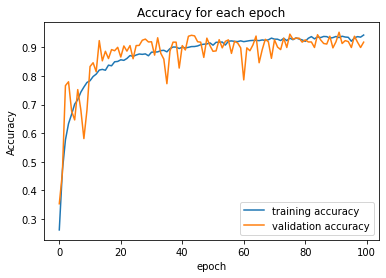

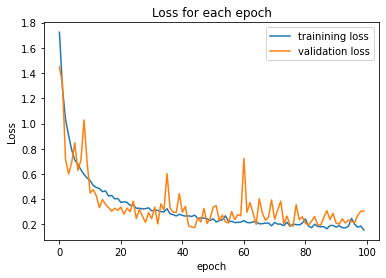

In [0]:
plot_learning_curve(training_history_4)

In [0]:
score = model.evaluate_generator(validation_image_generator, 150)
print('Accuracy on test set = %.2f%%' % (score[1] * 100))

Accuracy on test set = 92.69%


### Model 5

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['acc'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 146, 146, 16)      416       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 69, 69, 32)        12832     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 64)        51264     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 64)       

In [0]:
training_history_5 = train_on_generator(model, training_image_generator, validation_image_generator)

In [0]:
# Save model
model.save_weights(root_path + 'model_5.hdf5')

In [0]:
# Load model
model.load_weights(root_path + 'model_5.hdf5')

In [0]:
plot_learning_curve(training_history_5)

NameError: ignored

In [0]:
score = model.evaluate_generator(test_image_generator, 150)
print('Accuracy on test set = %.2f%%' % (score[1] * 100))

Accuracy on test set = 89.33%


### Model 6

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['acc'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 146, 146, 16)      416       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 69, 69, 32)        12832     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 30, 30, 64)        51264     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 14400)            

In [0]:
training_history_6 = train_on_generator(model, training_image_generator, validation_image_generator)

In [0]:
# Save model
model.save_weights(root_path + 'model_6.hdf5')

In [0]:
# Load model
model.load_weights(root_path + 'model_6.hdf5')

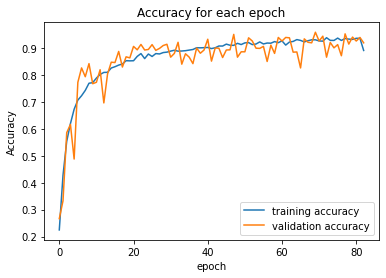

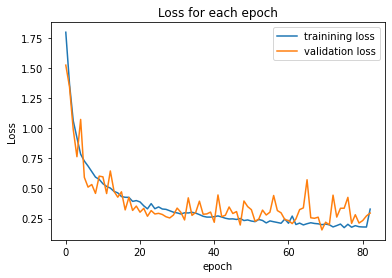

In [0]:
plot_learning_curve(training_history_6)

In [0]:
score = model.evaluate_generator(test_image_generator, 150)
print('Accuracy on test set = %.2f%%' % (score[1] * 100))

Accuracy on test set = 87.38%


# **Phase 4: Effects of Augmentation**

### Working with Unaugmented data

In [0]:
import numpy as np

scores = []

#### 0% Augmentation

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale image value from [0-255] to [0, 1]
test_generator = ImageDataGenerator(rescale=1./255)

# Creating a pipeline for flow of images from local directory
test_image_generator = test_generator.flow_from_directory(
    test_data_dir, 
    target_size=(150, 150), 
    batch_size=25, 
    class_mode='categorical',
    color_mode='grayscale'
)

# Creating a pipeline for flow of images from local directory
validation_image_generator = test_generator.flow_from_directory(
    val_data_dir, 
    target_size=(150, 150), 
    batch_size=25, 
    class_mode='categorical',
    color_mode='grayscale'
)

# Creating a pipeline for flow of images from local directory
training_image_generator = test_generator.flow_from_directory(
    train_data_dir, 
    target_size=(150, 150), 
    batch_size=50, 
    class_mode='categorical',
    color_mode='grayscale'
)

Found 150 images belonging to 6 classes.
Found 150 images belonging to 6 classes.
Found 1500 images belonging to 6 classes.


In [0]:
model = init_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 146, 146, 16)      416       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 69, 69, 32)        12832     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 64)        51264     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 14400)            

In [0]:
history_0 = train_on_generator(model, training_image_generator, validation_image_generator, patience=5)

In [0]:
# Save model
model.save_weights(root_path + 'phase4_0.hdf5')

In [0]:
# Load model
model.load_weights(root_path + 'phase4_0.hdf5')

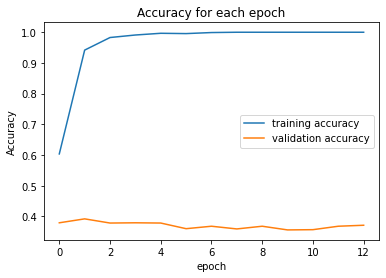

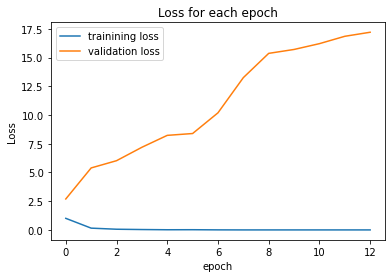

Instructions for updating:
Please use Model.evaluate, which supports generators.
Accuracy on test set = 41.33%


In [0]:
plot_learning_curve(history_0)
score = model.evaluate_generator(validation_image_generator, 150)
print('Accuracy on test set = %.2f%%' % (score[1] * 100))

In [0]:
score = model.evaluate_generator(validation_image_generator, 150)
print('Accuracy on test set = %.2f%%' % (score[1] * 100))
scores.append(score[1] * 100)

Accuracy on test set = 41.33%


### Working with Augmented data

#### 25% Augmentation

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify the different transformation that can be performed on the image
augmented_image_generator = ImageDataGenerator(
    # Commented out to perform overfitting
    rotation_range=45,
    width_shift_range=.25,
    height_shift_range=.25,
    shear_range=.25,
    zoom_range=.25,
    horizontal_flip = True,
    rescale=1./225,
    fill_mode='nearest'
)

In [0]:

# Create training pipeline
training_image_generator = augmented_image_generator.flow_from_directory(
    train_data_dir, 
    target_size=(150,150), 
    batch_size=50, 
    class_mode='categorical',
    color_mode='grayscale'
)

Found 1500 images belonging to 6 classes.


In [0]:
model = init_model()

In [0]:
history_1 = train_on_generator(model, training_image_generator, validation_image_generator, patience=5)

Epoch 1/100
100/100 [==============================] - 27s 268ms/step - loss: 1.7327 - acc: 0.2458 - val_loss: 1.6614 - val_acc: 0.2088
Epoch 2/100
100/100 [==============================] - 27s 266ms/step - loss: 1.3591 - acc: 0.4306 - val_loss: 1.2238 - val_acc: 0.4776
Epoch 3/100
100/100 [==============================] - 27s 265ms/step - loss: 1.1834 - acc: 0.5062 - val_loss: 0.8868 - val_acc: 0.6432
Epoch 4/100
100/100 [==============================] - 27s 265ms/step - loss: 1.0653 - acc: 0.5564 - val_loss: 0.8830 - val_acc: 0.6176
Epoch 5/100
100/100 [==============================] - 27s 266ms/step - loss: 0.9653 - acc: 0.5972 - val_loss: 1.6168 - val_acc: 0.3648
Epoch 6/100
100/100 [==============================] - 27s 266ms/step - loss: 0.9520 - acc: 0.6150 - val_loss: 0.6695 - val_acc: 0.7768
Epoch 7/100
100/100 [==============================] - 26s 265ms/step - loss: 0.8910 - acc: 0.6218 - val_loss: 0.5854 - val_acc: 0.8360
Epoch 8/100
100/100 [===========================

In [0]:
# Save model
model.save_weights(root_path + 'phase4_1.hdf5')

In [0]:
# Load model
model.load_weights(root_path + 'phase4_1.hdf5')

In [0]:
score = model.evaluate_generator(validation_image_generator, 150)
print('Accuracy on test set = %.2f%%' % (score[1] * 100))
scores.append(score[1] * 100)


Accuracy on test set = 93.40%


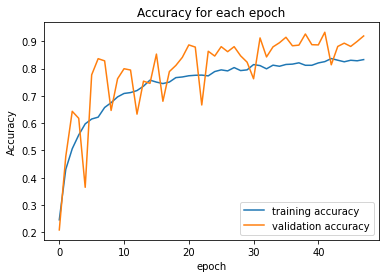

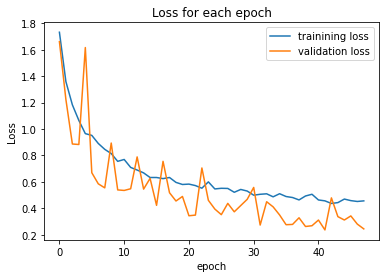

Accuracy on test set = 93.25%


In [0]:
get_performance(model, history_1, validation_image_generator)

#### 50% Augmentation

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify the different transformation that can be performed on the image
augmented_image_generator = ImageDataGenerator(
    # Commented out to perform overfitting
    rotation_range=90,
    width_shift_range=.5,
    height_shift_range=.5,
    shear_range=.5,
    zoom_range=.5,
    horizontal_flip = True,
    rescale=1./225,
    fill_mode='nearest'
)

# Create training pipeline
training_image_generator = augmented_image_generator.flow_from_directory(
    train_data_dir, 
    target_size=(150,150), 
    batch_size=50, 
    class_mode='categorical',
    color_mode='grayscale'
)

Found 1500 images belonging to 6 classes.


In [0]:
model = init_model()

In [0]:
history_2 = train_on_generator(model, training_image_generator, validation_image_generator, patience=5)

Epoch 1/100
100/100 [==============================] - 27s 270ms/step - loss: 1.7950 - acc: 0.1802 - val_loss: 1.7145 - val_acc: 0.3208
Epoch 2/100
100/100 [==============================] - 27s 268ms/step - loss: 1.7132 - acc: 0.2568 - val_loss: 1.5046 - val_acc: 0.3232
Epoch 3/100
100/100 [==============================] - 27s 270ms/step - loss: 1.6175 - acc: 0.3136 - val_loss: 1.4550 - val_acc: 0.3432
Epoch 4/100
100/100 [==============================] - 27s 269ms/step - loss: 1.5554 - acc: 0.3316 - val_loss: 1.1259 - val_acc: 0.6448
Epoch 5/100
100/100 [==============================] - 27s 267ms/step - loss: 1.4946 - acc: 0.3666 - val_loss: 1.0114 - val_acc: 0.5928
Epoch 6/100
100/100 [==============================] - 27s 268ms/step - loss: 1.4474 - acc: 0.3784 - val_loss: 0.9219 - val_acc: 0.5960
Epoch 7/100
100/100 [==============================] - 27s 269ms/step - loss: 1.3966 - acc: 0.4056 - val_loss: 0.9463 - val_acc: 0.6112
Epoch 8/100
100/100 [===========================

In [0]:
model.save_weights(root_path + 'phase4_2.hdf5')

In [0]:
model.load_weights(root_path + 'phase4_2.hdf5')

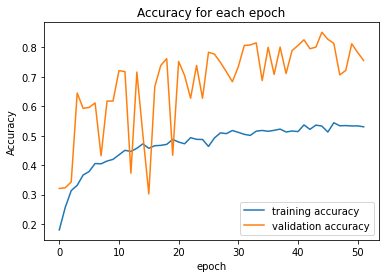

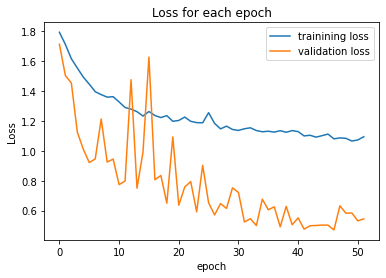

Accuracy on test set = 84.67%


In [0]:
get_performance(model, history_2, validation_image_generator)

In [0]:
score = model.evaluate_generator(validation_image_generator, 150)
print('Accuracy on test set = %.2f%%' % (score[1] * 100))
scores.append(score[1] * 100)


Accuracy on test set = 84.77%


#### 75% Augmentation

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify the different transformation that can be performed on the image
augmented_image_generator = ImageDataGenerator(
    # Commented out to perform overfitting
    rotation_range=135,
    width_shift_range=.75,
    height_shift_range=.75,
    shear_range=.75,
    zoom_range=.75,
    horizontal_flip = True,
    rescale=1./225,
    fill_mode='nearest'
)

# Create training pipeline
training_image_generator = augmented_image_generator.flow_from_directory(
    train_data_dir, 
    target_size=(150,150), 
    batch_size=50, 
    class_mode='categorical',
    color_mode='grayscale'
)

Found 1500 images belonging to 6 classes.


In [0]:
model = init_model()

In [0]:
history_3 = train_on_generator(model, training_image_generator, validation_image_generator, patience=5)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
100/100 [==============================] - 29s 294ms/step - loss: 1.7952 - acc: 0.1584 - val_loss: 1.7902 - val_acc: 0.2067
Epoch 2/100
100/100 [==============================] - 29s 293ms/step - loss: 1.7908 - acc: 0.1730 - val_loss: 1.7499 - val_acc: 0.2187
Epoch 3/100
100/100 [==============================] - 30s 295ms/step - loss: 1.7787 - acc: 0.2072 - val_loss: 1.6370 - val_acc: 0.3020
Epoch 4/100
100/100 [==============================] - 29s 292ms/step - loss: 1.7472 - acc: 0.2290 - val_loss: 1.6850 - val_acc: 0.3007
Epoch 5/100
100/100 [==============================] - 29s 293ms/step - loss: 1.7310 - acc: 0.2324 - val_loss: 1.4805 - val_acc: 0.3567
Epoch 6/100
100/100 [==============================] - 30s 295ms/step - loss: 1.7108 - acc: 0.2576 - val_loss: 1.4199 - val_acc: 0.4200
Epoch 7/100
100/100 [==============================] - 30s 295ms/step - loss: 1.6843 - acc: 0.2572 - val_los

In [0]:
model.save_weights(root_path + 'phase4_3.hdf5')

In [0]:
model.load_weights(root_path + 'phase4_3.hdf5')

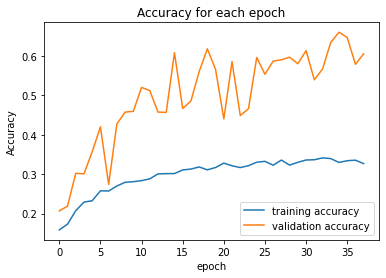

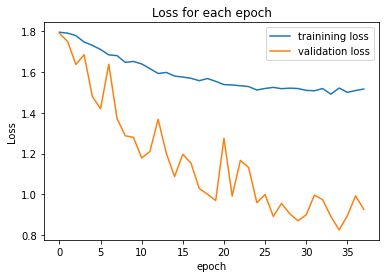

Instructions for updating:
Please use Model.evaluate, which supports generators.
Accuracy on test set = 66.67%


In [0]:
get_performance(model, history_3, validation_image_generator)

In [0]:
score = model.evaluate_generator(validation_image_generator, 150)
print('Accuracy on test set = %.2f%%' % (score[1] * 100))
scores.append(score[1] * 100)


Accuracy on test set = 66.56%


#### 100% Augmentation

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify the different transformation that can be performed on the image
augmented_image_generator = ImageDataGenerator(
    # Commented out to perform overfitting
    rotation_range=180,
    width_shift_range=1,
    height_shift_range=1,
    shear_range=1,
    zoom_range=1,
    horizontal_flip = True,
    rescale=1./225,
    fill_mode='nearest'
)

# Create training pipeline
training_image_generator = augmented_image_generator.flow_from_directory(
    train_data_dir, 
    target_size=(150,150), 
    batch_size=50, 
    class_mode='categorical',
    color_mode='grayscale'
)

Found 1500 images belonging to 6 classes.


In [0]:
model = init_model()

In [0]:
history_4 = train_on_generator(model, training_image_generator, validation_image_generator, patience=5)

In [0]:
model.save_weights(root_path + 'phase4_4.hdf5')

In [0]:
model.load_weights(root_path + 'phase4_4.hdf5')

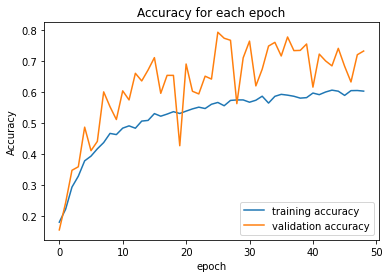

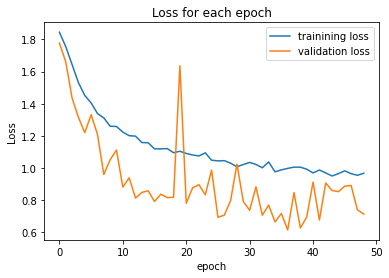

Accuracy on test set = 75.96%


In [0]:
get_performance(model, history_4, validation_image_generator)

In [0]:
score = model.evaluate_generator(validation_image_generator, 150)
print('Accuracy on test set = %.2f%%' % (score[1] * 100))
scores.append(score[1] * 100)

Accuracy on test set = 75.97%


In [0]:
print(scores)

[41.333332657814026, 93.33333373069763, 84.77333188056946, 66.56000018119812, 75.97333192825317]


In [0]:
aug_range = [0, 25, 50, 75, 100]

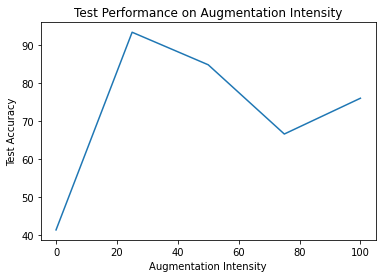

In [0]:
import matplotlib.pyplot as plt

plt.plot(aug_range, scores)
plt.xlabel('Augmentation Intensity')
plt.ylabel('Test Accuracy')
plt.title('Test Performance on Augmentation Intensity')
plt.show()

Found 1500 images belonging to 6 classes.
Performance of model with [ 0 %]  augmentation:


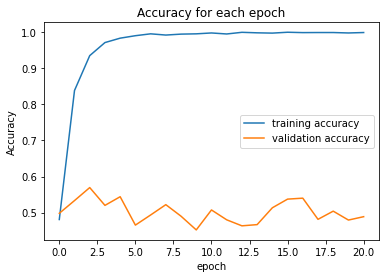

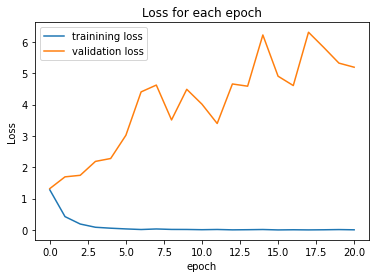

Accuracy on test set = 54.02%
Found 1500 images belonging to 6 classes.
Performance of model with [ 5 %]  augmentation:


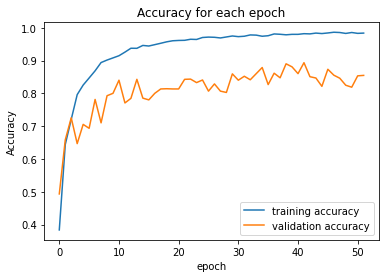

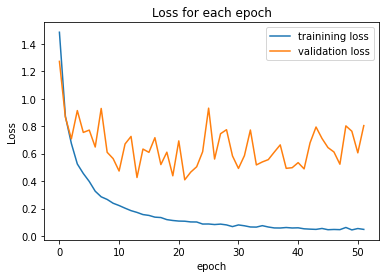

Accuracy on test set = 82.07%
Found 1500 images belonging to 6 classes.
Performance of model with [ 10 %]  augmentation:


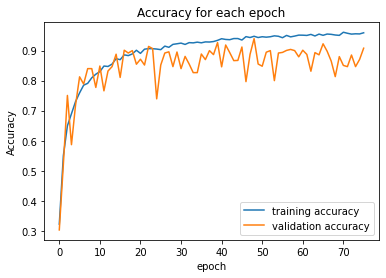

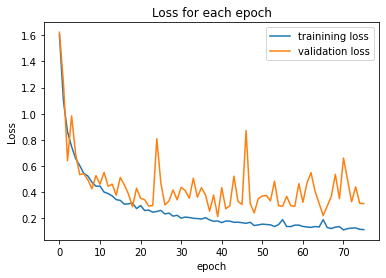

Accuracy on test set = 92.67%
Found 1500 images belonging to 6 classes.
Performance of model with [ 15 %]  augmentation:


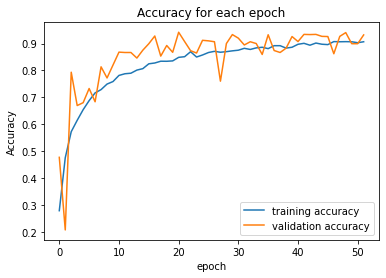

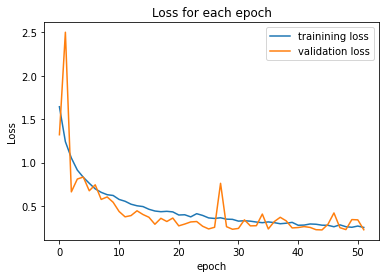

Accuracy on test set = 89.31%
Found 1500 images belonging to 6 classes.
Performance of model with [ 20 %]  augmentation:


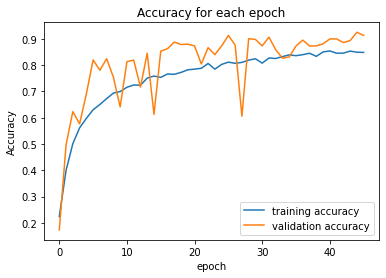

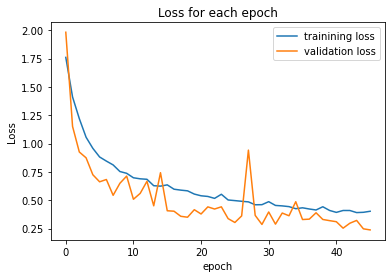

Accuracy on test set = 90.09%
Found 1500 images belonging to 6 classes.
Performance of model with [ 25 %]  augmentation:


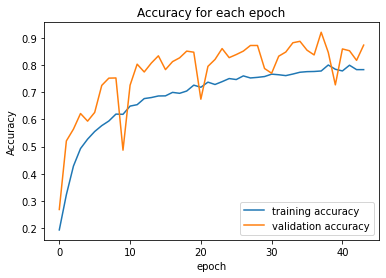

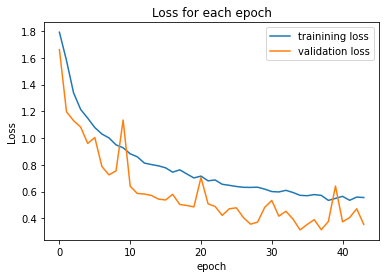

Accuracy on test set = 85.33%
Found 1500 images belonging to 6 classes.
Performance of model with [ 30 %]  augmentation:


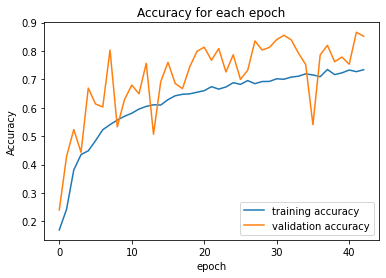

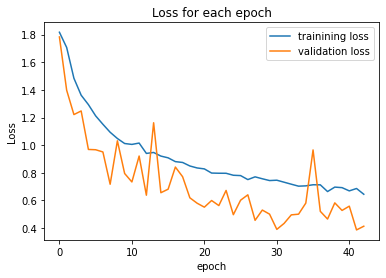

Accuracy on test set = 87.27%
Found 1500 images belonging to 6 classes.
Performance of model with [ 35 %]  augmentation:


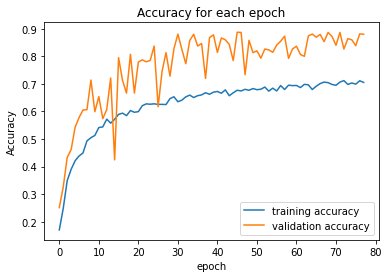

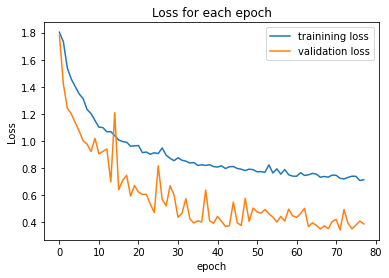

Accuracy on test set = 86.00%
Found 1500 images belonging to 6 classes.
Performance of model with [ 40 %]  augmentation:


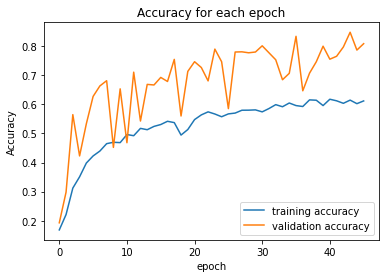

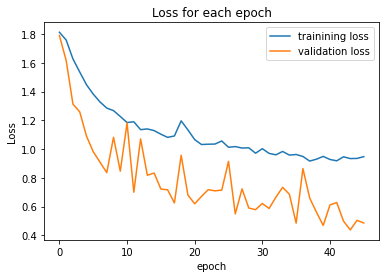

Accuracy on test set = 77.36%
Found 1500 images belonging to 6 classes.
Performance of model with [ 45 %]  augmentation:


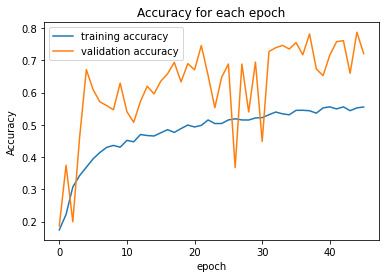

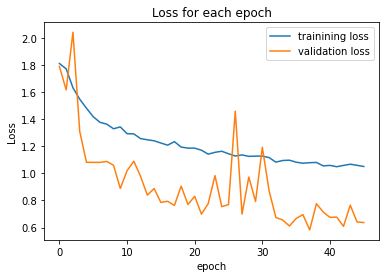

Accuracy on test set = 80.73%
Found 1500 images belonging to 6 classes.
Performance of model with [ 50 %]  augmentation:


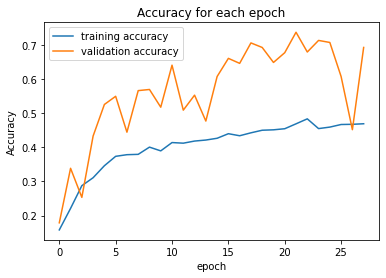

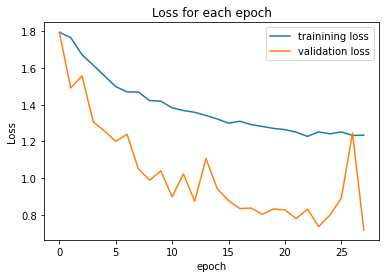

Accuracy on test set = 73.40%
Found 1500 images belonging to 6 classes.
Performance of model with [ 55 %]  augmentation:


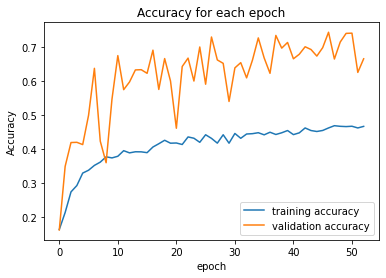

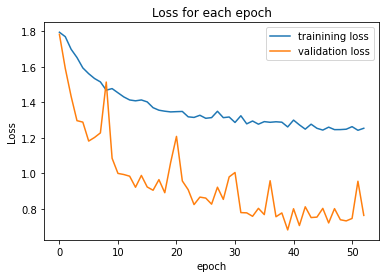

Accuracy on test set = 76.00%
Found 1500 images belonging to 6 classes.
Performance of model with [ 60 %]  augmentation:


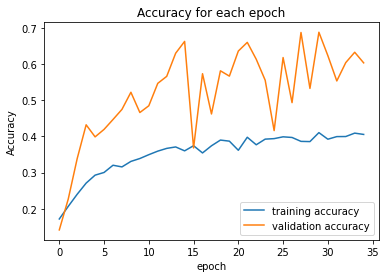

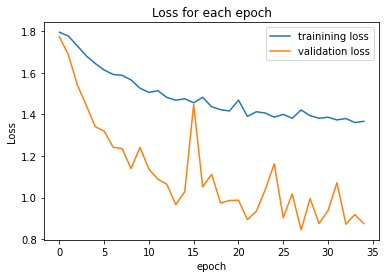

Accuracy on test set = 67.33%
Found 1500 images belonging to 6 classes.
Performance of model with [ 65 %]  augmentation:


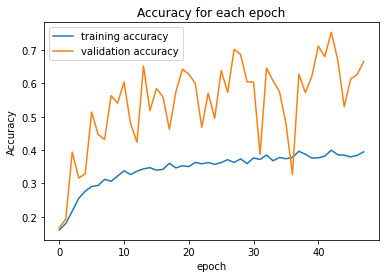

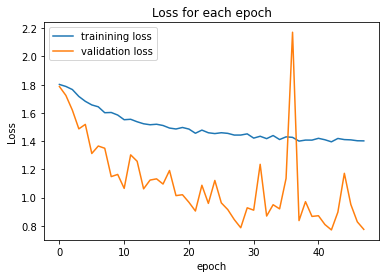

Accuracy on test set = 72.67%
Found 1500 images belonging to 6 classes.
Performance of model with [ 70 %]  augmentation:


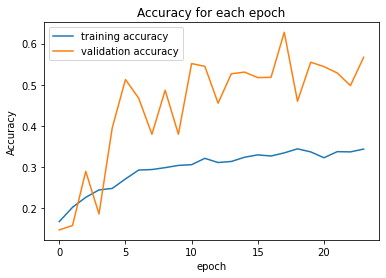

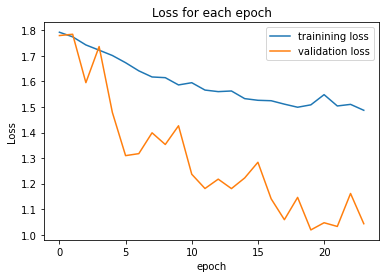

Accuracy on test set = 48.64%
Found 1500 images belonging to 6 classes.
Performance of model with [ 75 %]  augmentation:


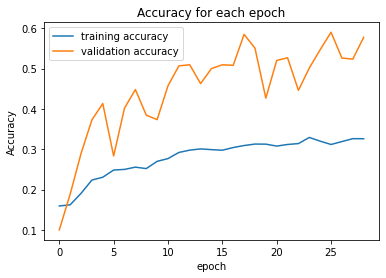

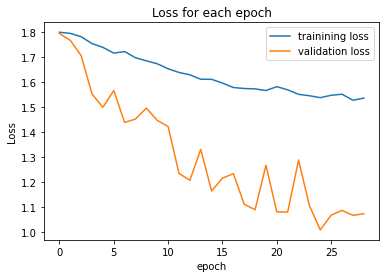

Accuracy on test set = 50.78%
Found 1500 images belonging to 6 classes.
Performance of model with [ 80 %]  augmentation:


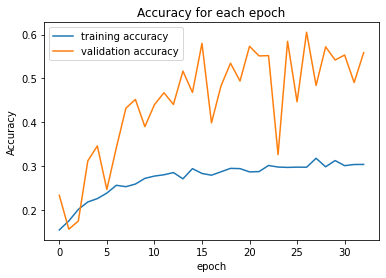

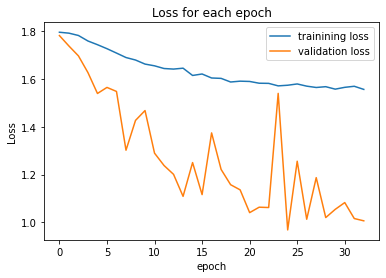

Accuracy on test set = 56.04%
Found 1500 images belonging to 6 classes.
Performance of model with [ 85 %]  augmentation:


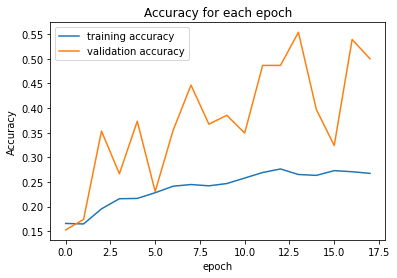

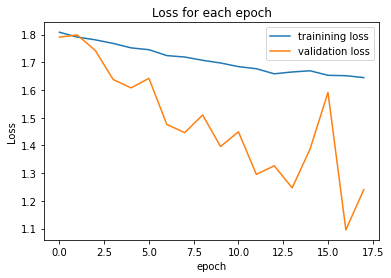

Accuracy on test set = 51.33%
Found 1500 images belonging to 6 classes.
Performance of model with [ 90 %]  augmentation:


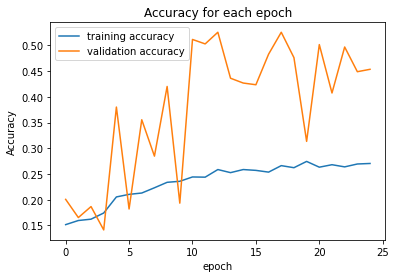

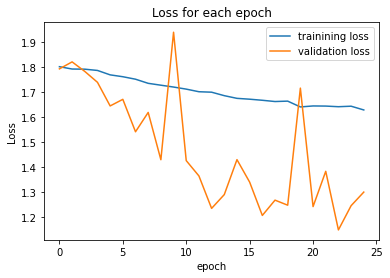

Accuracy on test set = 48.69%
Found 1500 images belonging to 6 classes.
Performance of model with [ 95 %]  augmentation:


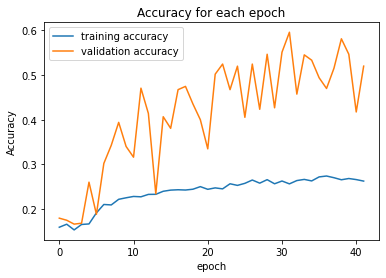

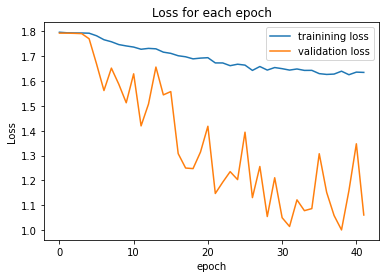

Accuracy on test set = 51.96%
Found 1500 images belonging to 6 classes.
Performance of model with [ 100 %]  augmentation:


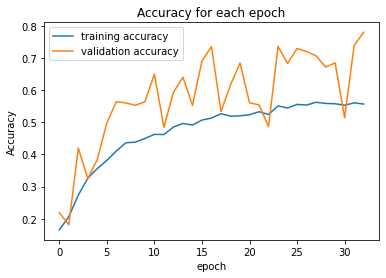

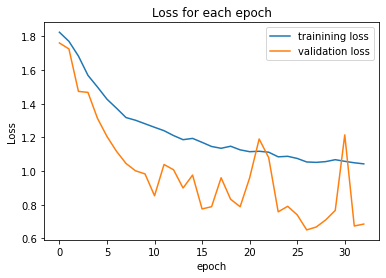

Accuracy on test set = 79.98%


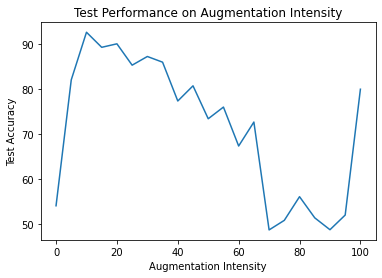

In [0]:
scores = []
aug_range = []

intensity_gap = 5
total_trained = int(100/intensity_gap) + 1

# Automate training on different augmented intensity and show test result
for i in range(total_trained):
  augmented_image_generator = set_augment_intensity(i * intensity_gap)

  # Create training pipeline
  training_image_generator = augmented_image_generator.flow_from_directory(
      train_data_dir, 
      target_size=(150,150), 
      batch_size=50, 
      class_mode='categorical',
      color_mode='grayscale'
  )

  model = init_model()
  history = train_on_generator(model, training_image_generator, validation_image_generator, patience=5, verbose=0)

  print('Performance of model with [', str(i * intensity_gap), '%]', ' augmentation:')
  score = get_performance(model, history, validation_image_generator)
  scores.append(score)
  aug_range.append(i * intensity_gap)

# Plot test performance on augmentation curve
plt.plot(aug_range, scores)
plt.xlabel('Augmentation Intensity')
plt.ylabel('Test Accuracy')
plt.title('Test Performance on Augmentation Intensity')
plt.show()

Found 1500 images belonging to 6 classes.
Performance of model with [ 0 %]  augmentation:


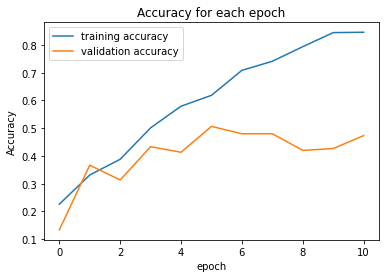

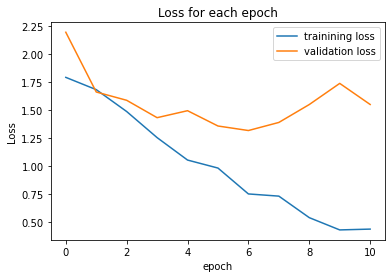

Accuracy on test set = 50.00%
Found 1500 images belonging to 6 classes.
Performance of model with [ 5 %]  augmentation:


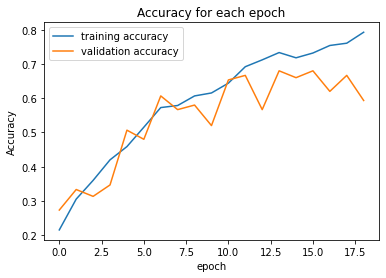

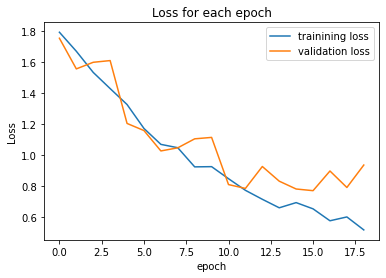

Accuracy on test set = 71.33%
Found 1500 images belonging to 6 classes.
Performance of model with [ 10 %]  augmentation:


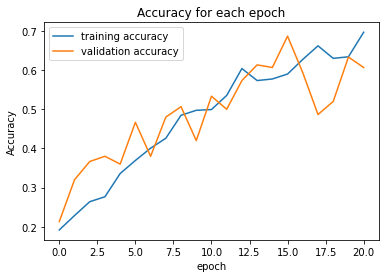

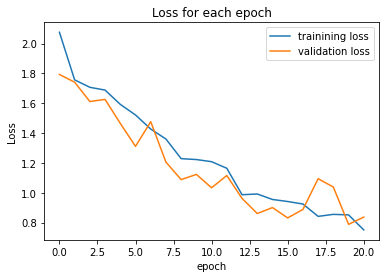

Accuracy on test set = 63.33%
Found 1500 images belonging to 6 classes.
Performance of model with [ 15 %]  augmentation:


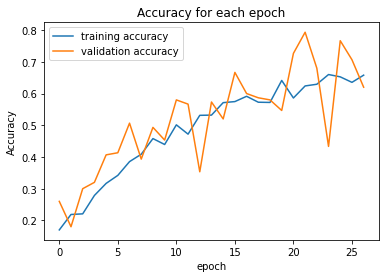

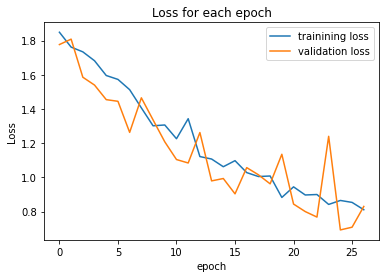

Accuracy on test set = 82.00%
Found 1500 images belonging to 6 classes.
Performance of model with [ 20 %]  augmentation:


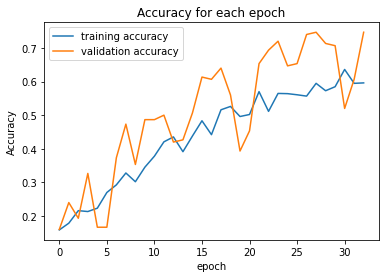

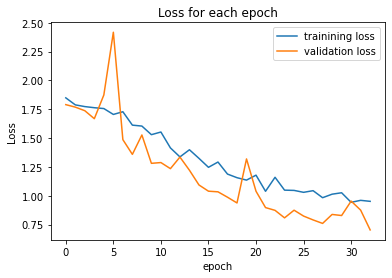

Accuracy on test set = 82.67%
Found 1500 images belonging to 6 classes.
Performance of model with [ 25 %]  augmentation:


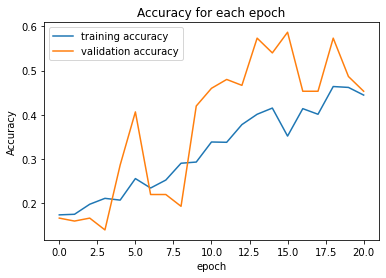

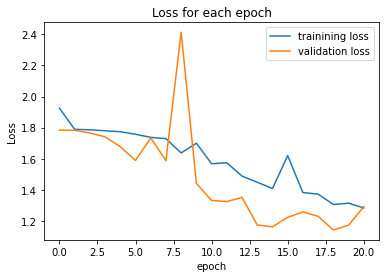

Accuracy on test set = 58.67%
Found 1500 images belonging to 6 classes.
Performance of model with [ 30 %]  augmentation:


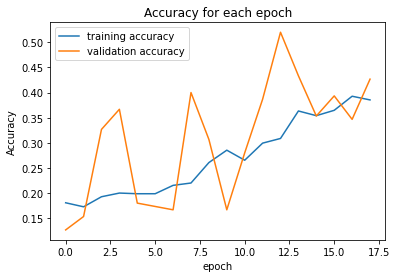

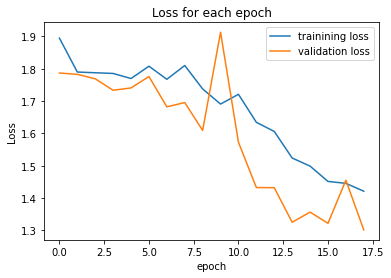

Accuracy on test set = 42.67%
Found 1500 images belonging to 6 classes.
Performance of model with [ 35 %]  augmentation:


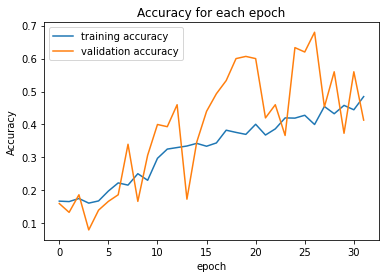

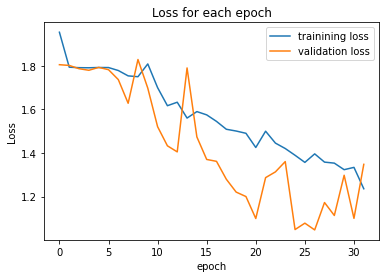

Accuracy on test set = 68.00%
Found 1500 images belonging to 6 classes.
Performance of model with [ 40 %]  augmentation:


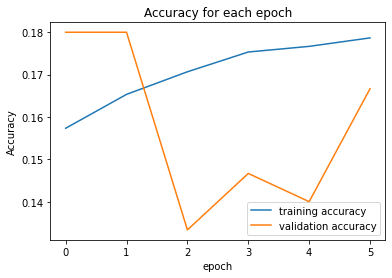

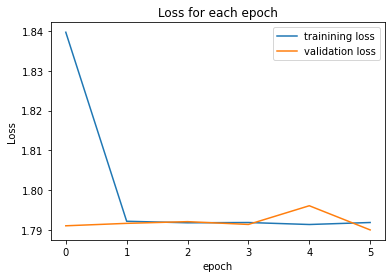

Accuracy on test set = 16.67%
Found 1500 images belonging to 6 classes.
Performance of model with [ 45 %]  augmentation:


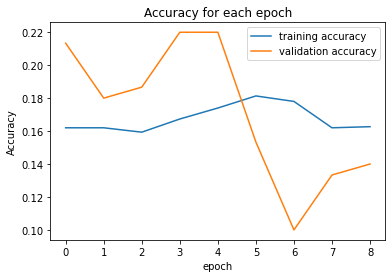

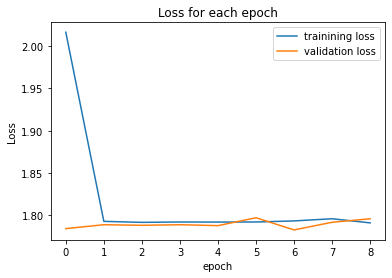

Accuracy on test set = 14.67%
Found 1500 images belonging to 6 classes.
Performance of model with [ 50 %]  augmentation:


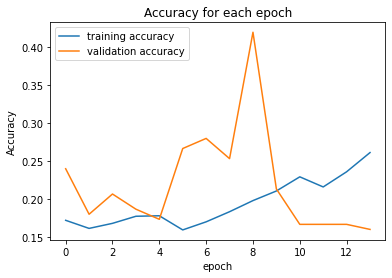

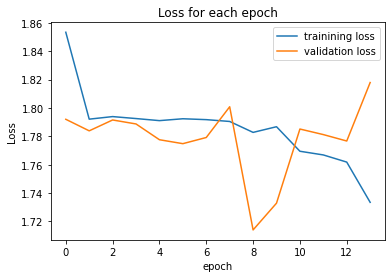

Accuracy on test set = 34.67%
Found 1500 images belonging to 6 classes.
Performance of model with [ 55 %]  augmentation:


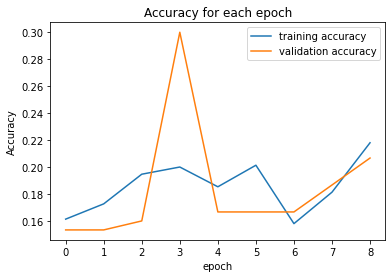

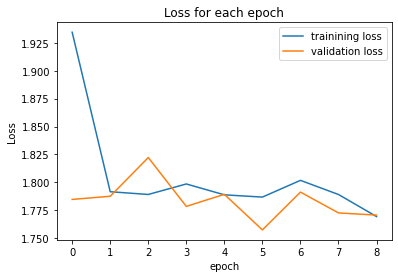

Accuracy on test set = 17.33%
Found 1500 images belonging to 6 classes.
Performance of model with [ 60 %]  augmentation:


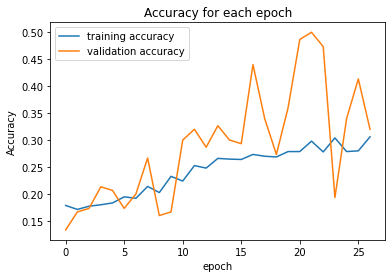

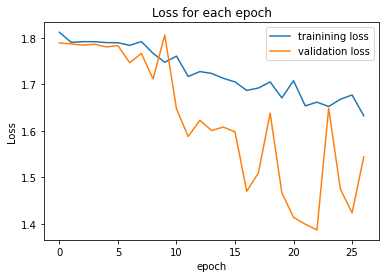

Accuracy on test set = 46.67%
Found 1500 images belonging to 6 classes.
Performance of model with [ 65 %]  augmentation:


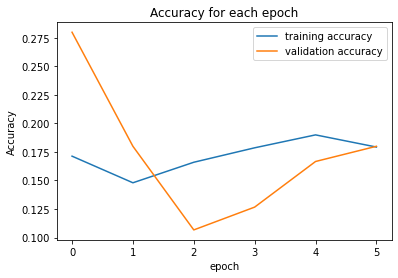

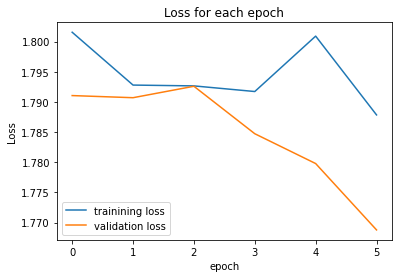

Accuracy on test set = 14.67%
Found 1500 images belonging to 6 classes.
Performance of model with [ 70 %]  augmentation:


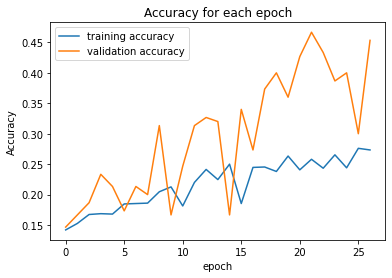

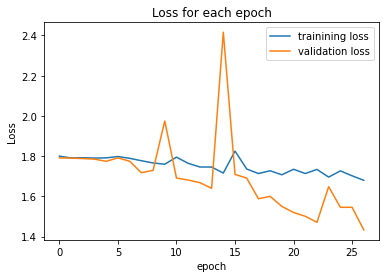

Accuracy on test set = 52.67%
Found 1500 images belonging to 6 classes.
Performance of model with [ 75 %]  augmentation:


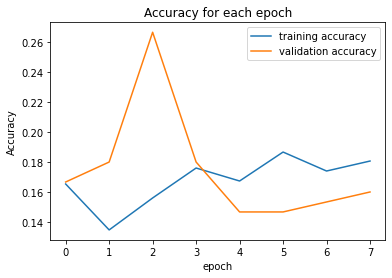

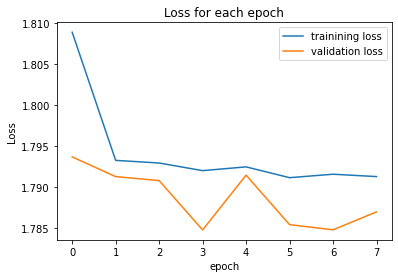

Accuracy on test set = 18.00%
Found 1500 images belonging to 6 classes.
Performance of model with [ 80 %]  augmentation:


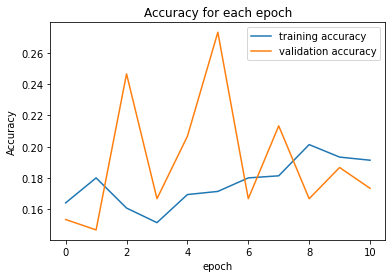

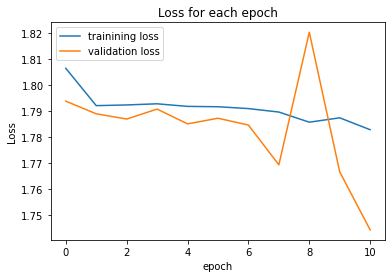

Accuracy on test set = 16.00%
Found 1500 images belonging to 6 classes.
Performance of model with [ 85 %]  augmentation:


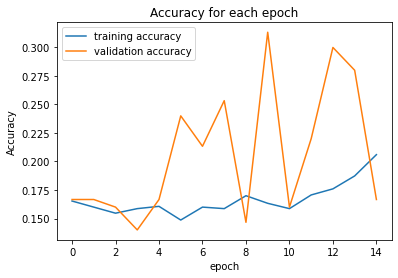

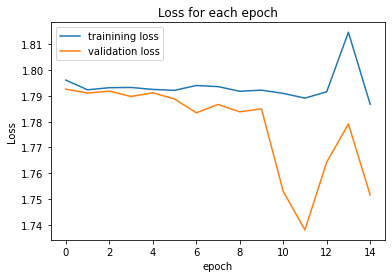

Accuracy on test set = 18.00%
Found 1500 images belonging to 6 classes.
Performance of model with [ 90 %]  augmentation:


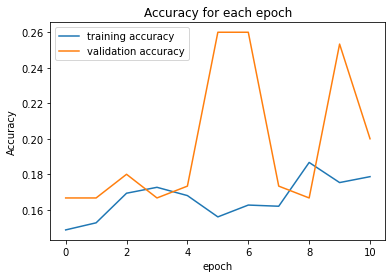

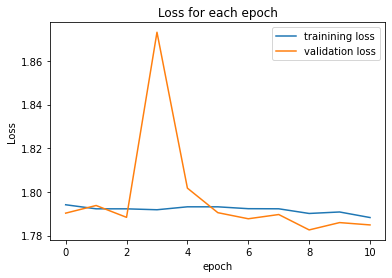

Accuracy on test set = 16.67%
Found 1500 images belonging to 6 classes.
Performance of model with [ 95 %]  augmentation:


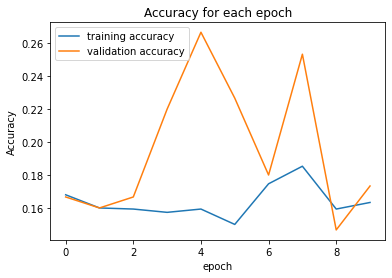

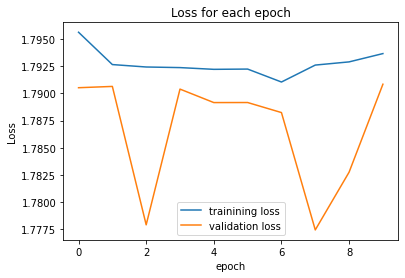

Accuracy on test set = 18.00%
Found 1500 images belonging to 6 classes.
Performance of model with [ 100 %]  augmentation:


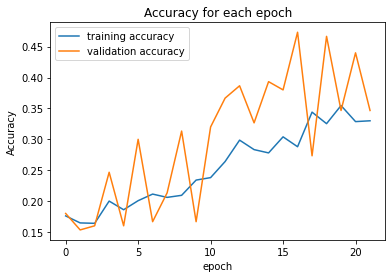

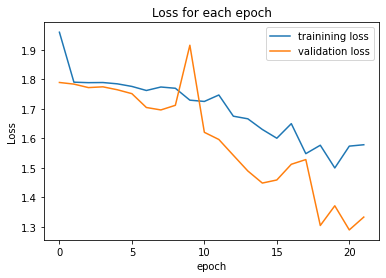

Accuracy on test set = 44.67%
Best model: best_model4.hd5


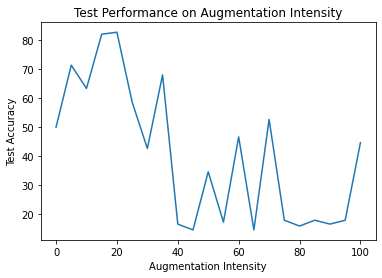

In [0]:
scores = []
aug_range = []

intensity_gap = 5
total_trained = int(100/intensity_gap) + 1

best_model_index = 0

# Automate training on different augmented intensity and show test result
for i in range(total_trained):
  augmented_image_generator = set_augment_intensity(i * intensity_gap)

  # Create training pipeline
  training_image_generator = augmented_image_generator.flow_from_directory(
      train_data_dir, 
      target_size=(150,150), 
      batch_size=150, 
      class_mode='categorical',
      color_mode='grayscale'
  )

  # Create standard model
  model = init_model()
  history = train_on_generator(
      model, training_image_generator,
      validation_image_generator, 
      best_model_filepath=root_path+'best_model'+str(i)+'.hdf5',  
      verbose=0,  
      steps_per_epoch=10,
      epochs=200
      )
  
  # Save weights
  model.load_weights(root_path + 'best_model' + str(i) + '.hdf5')

  # Print performance
  print('Performance of model with [', str(i * intensity_gap), '%]', ' augmentation:')
  score = get_performance(model, history, validation_image_generator)
  scores.append(score)
  aug_range.append(i * intensity_gap)

# Find the best model
best_model_index = np.array(scores).argmax()
print('Best model: best_model%d.hd5' % best_model_index)

# Plot test performance on augmentation curve
plt.plot(aug_range, scores)
plt.xlabel('Augmentation Intensity')
plt.ylabel('Test Accuracy')
plt.title('Test Performance on Augmentation Intensity')
plt.show()

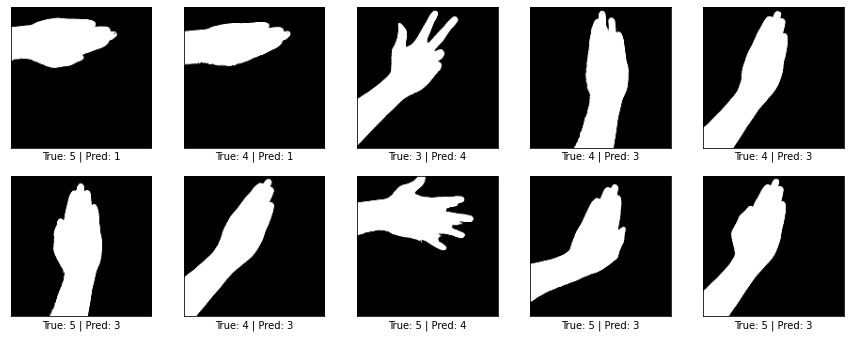

Error rate:  0.06666666666666667
Missed:  10 / 150


In [0]:
generator_mismatched(model, image_generator=validation_image_generator)

In [0]:
model = init_model()
model.load_weights(root_path + 'phase4_1.hdf5')
score = model.evaluate_generator(validation_image_generator, 1)
print(score[1])

0.9200000166893005


In [0]:
generator_mismatched(model, image_generator=validation_image_generator)

# Phase 5: Effects of Regularization

## Finding the best place to put BatchNormalization()

In [0]:
from tensorflow.keras import models
from tensorflow.keras import layers

# Function to test different places to put BatchNorm
def modelBatchNormLocation(location):
  model = models.Sequential()
  model.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(150, 150, 1)))
  # location 0
  if location == 0:
    model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  # location 1
  if location == 1:
    model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (5, 5), activation='relu'))
  # location 2
  if location == 2:
    model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  # location 3
  if location == 3:
    model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (5, 5), activation='relu'))
  # location 4
  if location == 4:
    model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  # location 5
  if location == 5:
    model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  # location 6
  if location == 6:
    model.add(layers.BatchNormalization())
  model.add(layers.Dense(128, activation='relu'))
  # location 7
  if location == 7:
    model.add(layers.BatchNormalization())
  model.add(layers.Dense(64, activation='relu'))
  # location 8
  if location == 8:
    model.add(layers.BatchNormalization())
  model.add(layers.Dense(6, activation='softmax'))
  
  model.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['acc'])
 
  return model

Setting BatchNorm in location  0


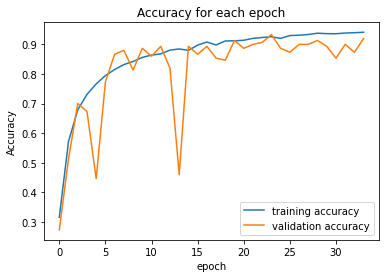

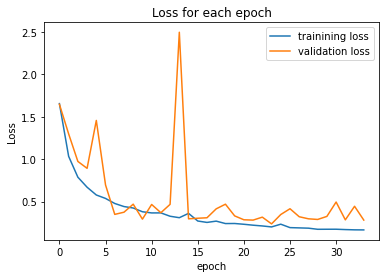

Accuracy = 92.00%
Setting BatchNorm in location  1


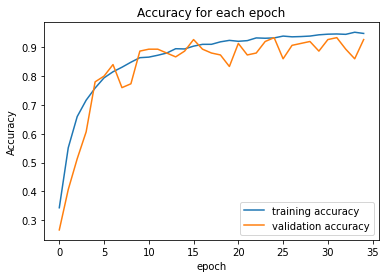

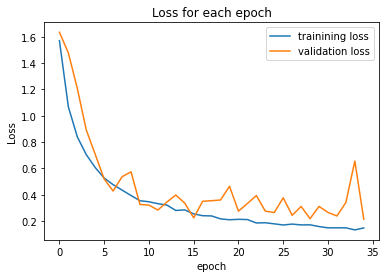

Accuracy = 92.67%
Setting BatchNorm in location  2


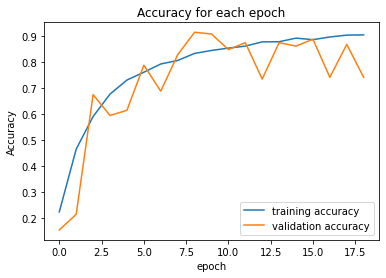

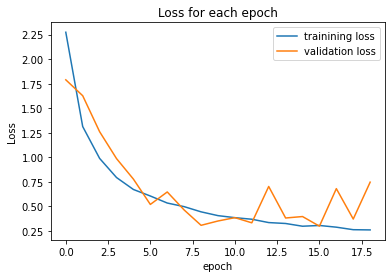

Accuracy = 74.00%
Setting BatchNorm in location  3


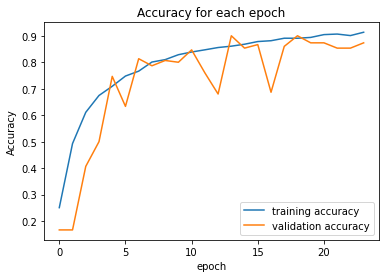

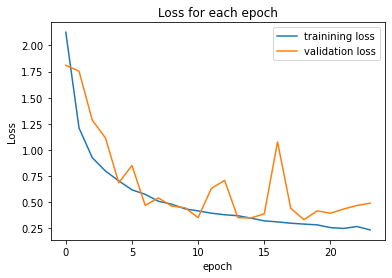

Accuracy = 87.33%
Setting BatchNorm in location  4


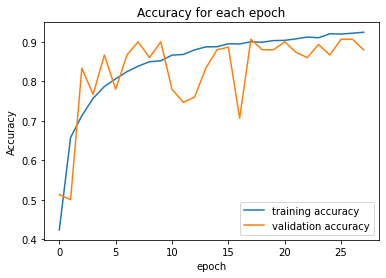

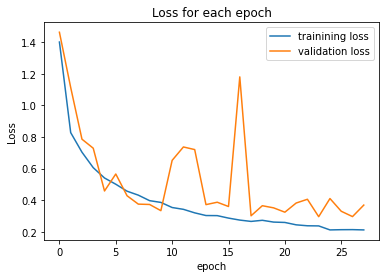

Accuracy = 88.00%
Setting BatchNorm in location  5


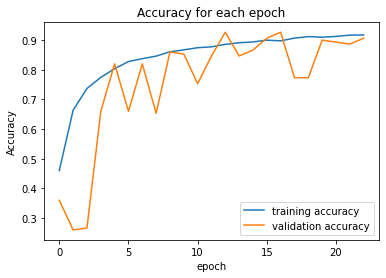

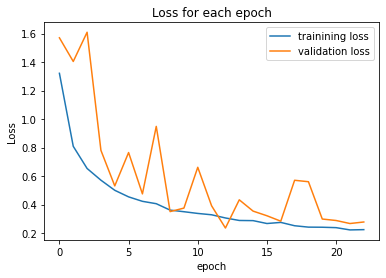

Accuracy = 90.67%
Setting BatchNorm in location  6


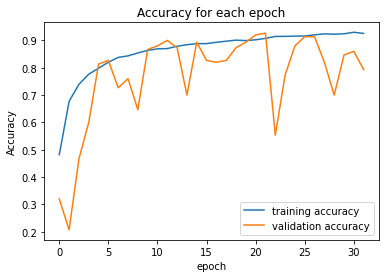

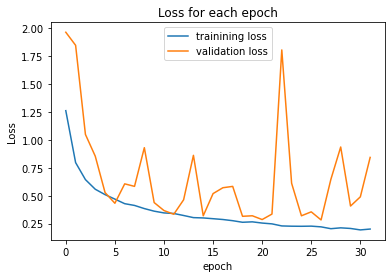

Accuracy = 79.33%
Setting BatchNorm in location  7


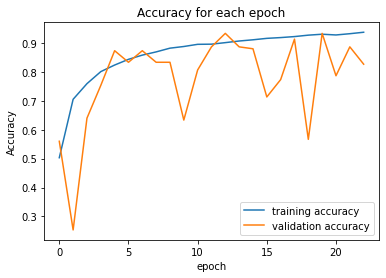

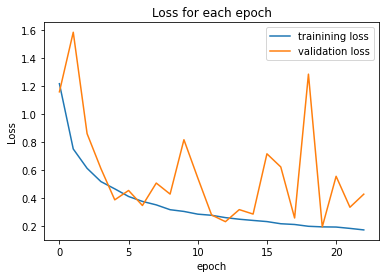

Accuracy = 82.67%
Setting BatchNorm in location  8


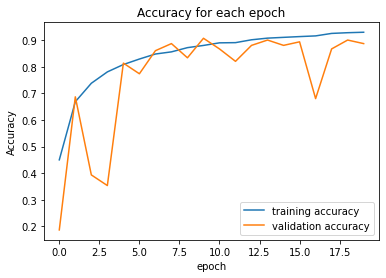

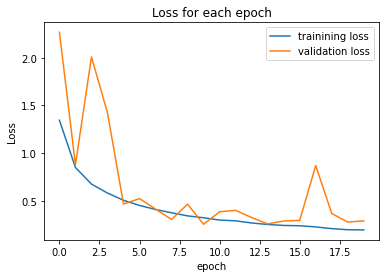

Accuracy = 88.67%
Best model performance score on the validation set is  92.66666769981384 %
Best location:  1


In [0]:
best_score = 0
best_model = modelBatchNormLocation(0)
best_location = 0
for i in range(9):
  print('Setting BatchNorm in location ', str(i))
  model = modelBatchNormLocation(i)
  history = train_on_generator(model, training_image_generator, 
                              validation_image_generator, 
                              root_path + 'Reg1.hdf5', verbose=0,
                              patience=10, epochs=500)
  this_score = get_performance(model, history, validation_image_generator)
  if this_score > best_score:
    model.save_weights(root_path + 'BestReg.hdf5')
    best_score = this_score
    best_model = model
    best_location = i
print('Best model performance score on the validation set is ',  str(best_score), '%')
print('Best location: ', str(best_location))

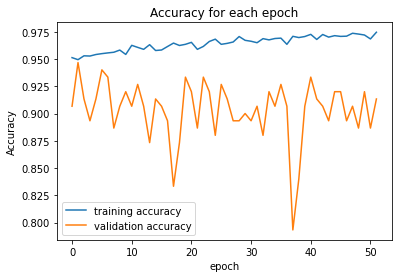

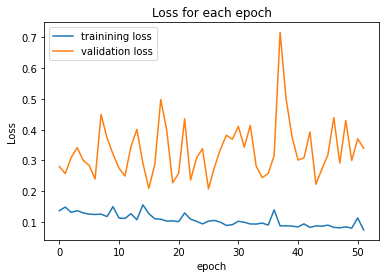

Accuracy = 91.33%


In [0]:
history = train_on_generator(best_model, training_image_generator, 
                              validation_image_generator, 
                              root_path + 'BestReg.hdf5', verbose=0,
                              patience=50, epochs=2000)
score = get_performance(best_model, history, validation_image_generator)

## Finding the best place to put DropOut()

In [0]:
from tensorflow.keras import models
from tensorflow.keras import layers

def modelDropOutLocation(location):
  model = models.Sequential()
  model.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(150, 150, 1)))
  # location 0
  if location == 0:
    model.add(layers.Dropout(.25))
  model.add(layers.MaxPooling2D((2, 2)))
  # location 1
  if location == 1:
    model.add(layers.Dropout(.25))
  model.add(layers.Conv2D(32, (5, 5), activation='relu'))
  # location 2
  if location == 2:
    model.add(layers.Dropout(.25))
  model.add(layers.MaxPooling2D((2, 2)))
  # location 3
  if location == 3:
    model.add(layers.Dropout(.25))
  model.add(layers.Conv2D(64, (5, 5), activation='relu'))
  # location 4
  if location == 4:
    model.add(layers.Dropout(.25))
  model.add(layers.MaxPooling2D((2, 2)))
  # location 5
  if location == 5:
    model.add(layers.Dropout(.25))
  model.add(layers.Flatten())
  # location 6
  if location == 6:
    model.add(layers.Dropout(.25))
  model.add(layers.Dense(128, activation='relu'))
  # location 7
  if location == 7:
    model.add(layers.Dropout(.25))
  model.add(layers.Dense(64, activation='relu'))
  # location 8
  if location == 8:
    model.add(layers.Dropout(.25))
  model.add(layers.Dense(6, activation='softmax'))
  
  model.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['acc'])
 
  return model

Setting DropOut in location  0


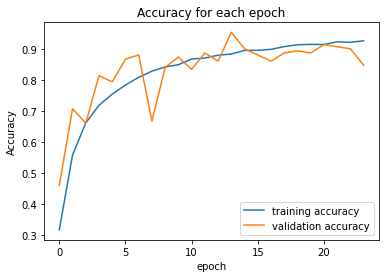

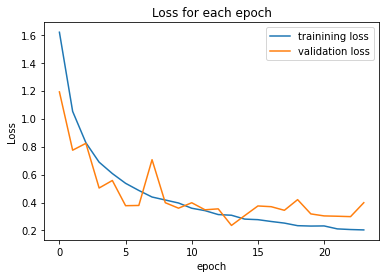

Instructions for updating:
Please use Model.evaluate, which supports generators.
Accuracy = 84.67%
Setting DropOut in location  1


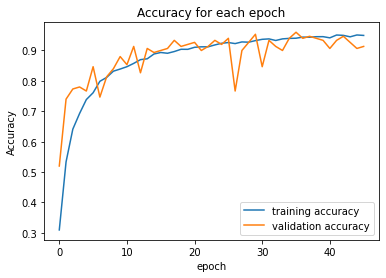

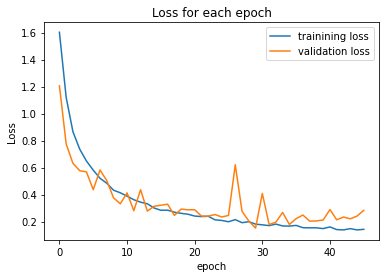

Accuracy = 91.33%
Setting DropOut in location  2


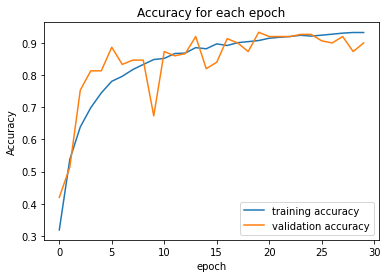

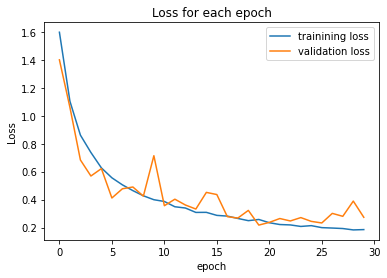

Accuracy = 90.00%
Setting DropOut in location  3


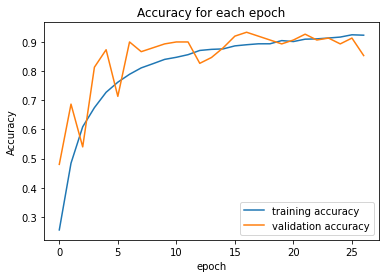

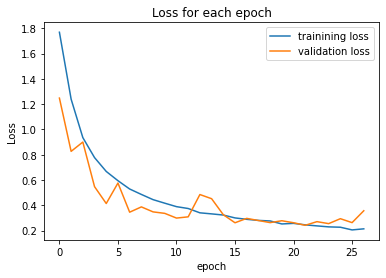

Accuracy = 85.33%
Setting DropOut in location  4


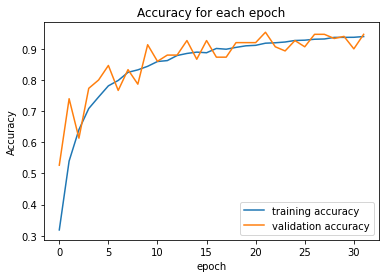

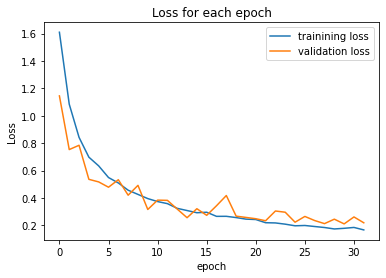

Accuracy = 94.67%
Setting DropOut in location  5


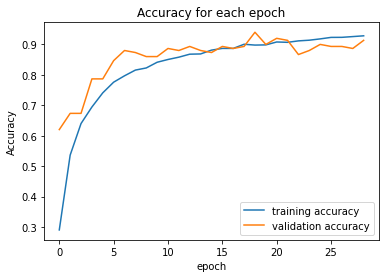

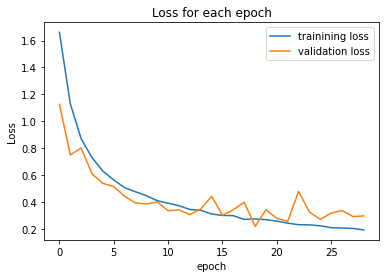

Accuracy = 91.33%
Setting DropOut in location  6


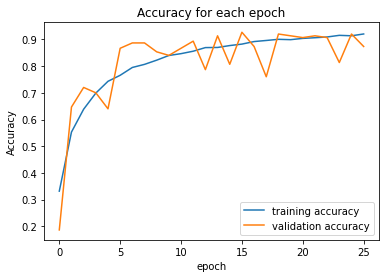

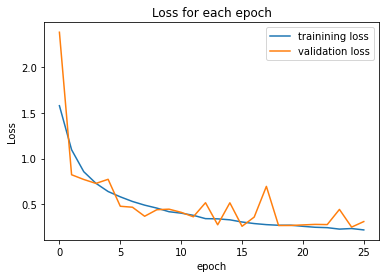

Accuracy = 87.33%
Setting DropOut in location  7


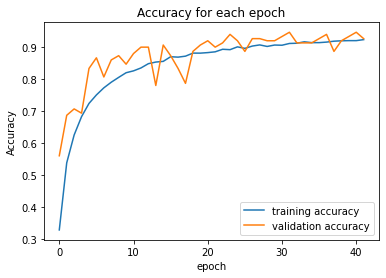

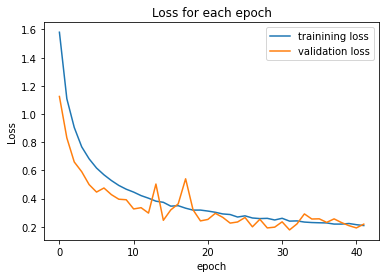

Accuracy = 92.67%
Setting DropOut in location  8


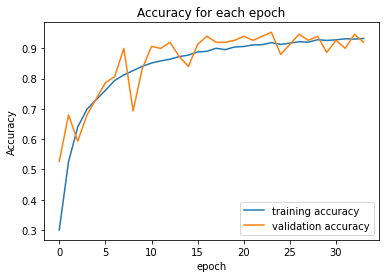

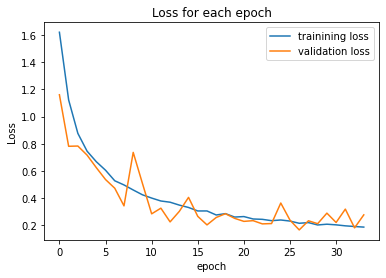

Accuracy = 92.00%
Best model performance score on the validation set is  94.66666579246521 %
Best location:  4


In [0]:
best_score = 0
best_model = modelDropOutLocation(0)
best_location = 0
for i in range(9):
  print('Setting DropOut in location ', str(i))
  model = modelDropOutLocation(i)
  history = train_on_generator(model, training_image_generator, 
                              validation_image_generator, 
                              root_path + 'Reg1.hdf5', verbose=0,
                              patience=10, epochs=500)
  this_score = get_performance(model, history, validation_image_generator)
  if this_score > best_score:
    model.save_weights(root_path + 'BestReg-dropout.hdf5')
    best_score = this_score
    best_model = model
    best_location = i
print('Best model performance score on the validation set is ',  str(best_score), '%')
print('Best location: ', str(best_location))

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.Dropout(.25))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['acc'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 146, 146, 16)      416       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 73, 73, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 73, 73, 16)        64        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 69, 69, 32)        12832     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 64)        51264     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 64)       

Epoch 1/100
100/100 - 88s - loss: 1.6341 - acc: 0.3334 - val_loss: 1.7263 - val_acc: 0.1733
Epoch 2/100
100/100 - 90s - loss: 1.0411 - acc: 0.5683 - val_loss: 1.5009 - val_acc: 0.4467
Epoch 3/100
100/100 - 88s - loss: 0.8114 - acc: 0.6590 - val_loss: 1.3888 - val_acc: 0.4733
Epoch 4/100
100/100 - 89s - loss: 0.7256 - acc: 0.7067 - val_loss: 1.1003 - val_acc: 0.5000
Epoch 5/100
100/100 - 89s - loss: 0.6136 - acc: 0.7474 - val_loss: 0.6932 - val_acc: 0.7733
Epoch 6/100
100/100 - 89s - loss: 0.5376 - acc: 0.7843 - val_loss: 0.7155 - val_acc: 0.6867
Epoch 7/100
100/100 - 89s - loss: 0.5043 - acc: 0.8026 - val_loss: 0.5350 - val_acc: 0.8000
Epoch 8/100
100/100 - 89s - loss: 0.4743 - acc: 0.8186 - val_loss: 0.4328 - val_acc: 0.8400
Epoch 9/100
100/100 - 90s - loss: 0.4324 - acc: 0.8310 - val_loss: 0.3929 - val_acc: 0.8667
Epoch 10/100
100/100 - 89s - loss: 0.4018 - acc: 0.8441 - val_loss: 0.3962 - val_acc: 0.8467
Epoch 11/100
100/100 - 89s - loss: 0.3715 - acc: 0.8605 - val_loss: 0.4148 - va

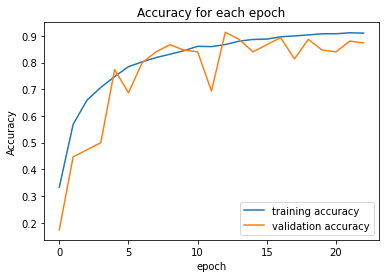

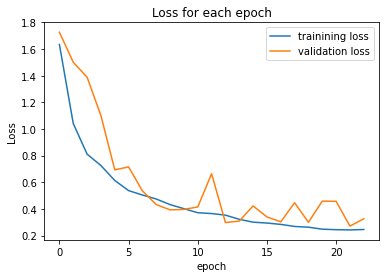

Accuracy = 87.33%


NameError: ignored

In [0]:
history = train_on_generator(model, training_image_generator, validation_image_generator)
get_performance(model, history, validation_image_generator)

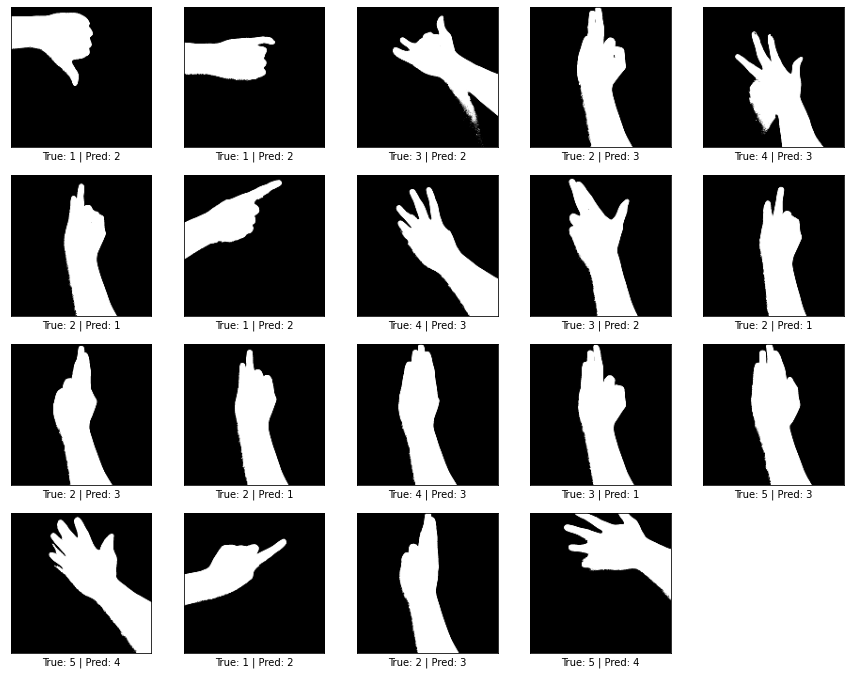

Error rate:  0.12666666666666668
Missed:  19 / 150


In [0]:
generator_mismatched(model, validation_image_generator)

Epoch 1/100
200/200 - 152s - loss: 1.3809 - acc: 0.4227 - val_loss: 1.0595 - val_acc: 0.5267
Epoch 2/100
200/200 - 151s - loss: 0.7768 - acc: 0.6761 - val_loss: 0.7152 - val_acc: 0.6800
Epoch 3/100
200/200 - 152s - loss: 0.5820 - acc: 0.7643 - val_loss: 0.6027 - val_acc: 0.7600
Epoch 4/100
200/200 - 151s - loss: 0.4814 - acc: 0.8137 - val_loss: 0.4302 - val_acc: 0.8333
Epoch 5/100
200/200 - 151s - loss: 0.4084 - acc: 0.8425 - val_loss: 0.4257 - val_acc: 0.8467
Epoch 6/100
200/200 - 151s - loss: 0.3470 - acc: 0.8681 - val_loss: 0.3199 - val_acc: 0.8800
Epoch 7/100
200/200 - 153s - loss: 0.3220 - acc: 0.8781 - val_loss: 0.4606 - val_acc: 0.8133
Epoch 8/100
200/200 - 151s - loss: 0.2953 - acc: 0.8872 - val_loss: 0.7565 - val_acc: 0.6733
Epoch 9/100
200/200 - 151s - loss: 0.2665 - acc: 0.9000 - val_loss: 0.2260 - val_acc: 0.9200
Epoch 10/100
200/200 - 155s - loss: 0.2475 - acc: 0.9060 - val_loss: 0.3068 - val_acc: 0.8867
Epoch 11/100
200/200 - 156s - loss: 0.2273 - acc: 0.9151 - val_loss: 

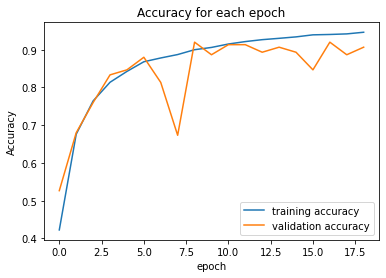

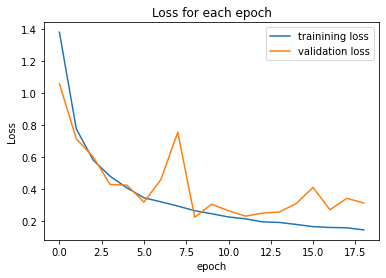

Accuracy on test set = 90.67%


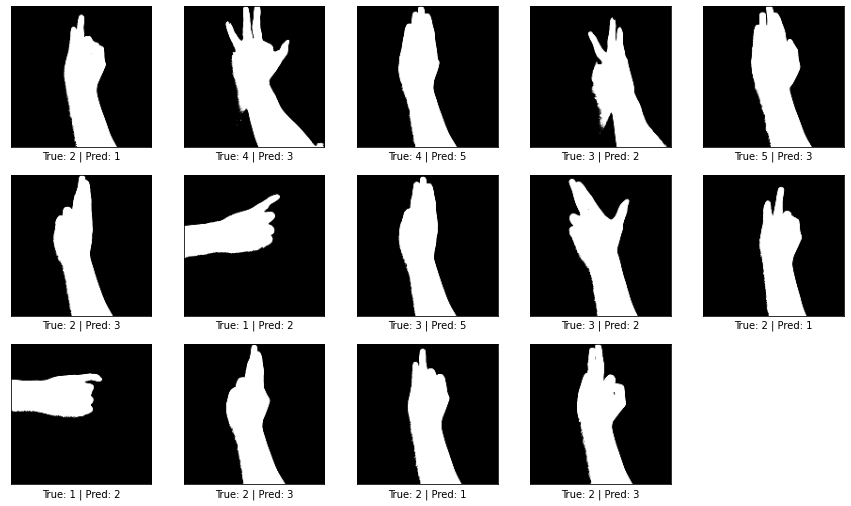

Error rate:  0.09333333333333334
Missed:  14 / 150


In [0]:
get_performance(model, history, validation_image_generator)

In [0]:
model = init_best_model()
model.load_weights(root_path + 'BestReg-dropout.hdf5')
generator_mismatched(model, validation_image_generator)

# **Phase 6: Using Pretrained Model**

- Changing to 3 channels gray scale images to fit pretrained input size.

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify the different transformation that can be performed on the image
augmented_image_generator = ImageDataGenerator(
    # Commented out to perform overfitting
    rotation_range=40,
    width_shift_range=.15,
    height_shift_range=.15,
    shear_range=.15,
    zoom_range=.15,
    horizontal_flip = True,
    rescale=1./225,
    fill_mode='nearest'
)
# Create training pipeline
training_image_generator = augmented_image_generator.flow_from_directory(
    train_data_dir, 
    target_size=(150,150), 
    batch_size=150, 
    class_mode='categorical'
)

# Rescale image value from [0-255] to [0, 1]
test_generator = ImageDataGenerator(rescale=1./255)

# Creating a pipeline for flow of images from local directory
test_image_generator = test_generator.flow_from_directory(
    test_data_dir, 
    target_size=(150, 150), 
    batch_size=150, 
    class_mode='categorical'
)

# Creating a pipeline for flow of images from local directory
validation_image_generator = test_generator.flow_from_directory(
    val_data_dir, 
    target_size=(150, 150), 
    batch_size=150, 
    class_mode='categorical'
)

Found 1500 images belonging to 6 classes.
Found 150 images belonging to 6 classes.
Found 150 images belonging to 6 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(150, 150, 3)


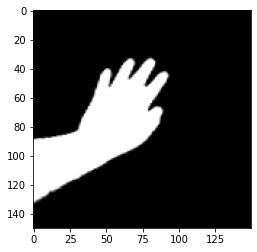

[0. 0. 0. 0. 0. 1.]


In [0]:
for batch in training_image_generator:
  images = batch[0]
  labels = batch[1]
  for i in range(len(labels)):
    print(images[i].shape)
    plt.imshow(images[i])
    plt.show()
    print(labels[i])
    break
  break

## Using VGG16

- Setup the convolution base

In [0]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

- Unfreezing the top convolution layer to learn our specific abstraction

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import models

# Set all to trainable
conv_base.trainable = True

# Loop freezing all except the top convolution layer
set_trainable = False
for layer in conv_base.layers:
  # Determine when to start un freezing
  if layer.name == 'block4_conv1':
    set_trainable = True

  if set_trainable:
    print(layer.name, '(is trainable)')
    layer.trainable = True
  else:
    print(layer.name, '(is not trainable)')
    layer.trainable = False

conv_base.summary()

input_1 (is not trainable)
block1_conv1 (is not trainable)
block1_conv2 (is not trainable)
block1_pool (is not trainable)
block2_conv1 (is not trainable)
block2_conv2 (is not trainable)
block2_pool (is not trainable)
block3_conv1 (is not trainable)
block3_conv2 (is not trainable)
block3_conv3 (is not trainable)
block3_pool (is not trainable)
block4_conv1 (is trainable)
block4_conv2 (is trainable)
block4_conv3 (is trainable)
block4_pool (is trainable)
block5_conv1 (is trainable)
block5_conv2 (is trainable)
block5_conv3 (is trainable)
block5_pool (is trainable)
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)  

- Adding top densely connected layer

In [0]:
from tensorflow.keras import optimizers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(2048, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

# Set an extremely low learning rate so we don't ruin the representations of all the trainable layers
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-5), 
              metrics=['acc'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              16779264  
_________________________________________________________________
dense_7 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 12294     
Total params: 35,702,598
Trainable params: 33,967,110
Non-trainable params: 1,735,488
_________________________________________________________________


In [0]:
history = train_on_generator(
      model, training_image_generator,
      validation_image_generator, 
      best_model_filepath=root_path+'VGG16.best_model.Reg-Drp50.1.hdf5'  
      )


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
100/100 - 178s - loss: 0.7574 - acc: 0.7089 - val_loss: 0.5407 - val_acc: 0.8000
Epoch 2/100
100/100 - 179s - loss: 0.3741 - acc: 0.8587 - val_loss: 0.3747 - val_acc: 0.8800
Epoch 3/100
100/100 - 179s - loss: 0.2691 - acc: 0.9036 - val_loss: 0.3410 - val_acc: 0.8800
Epoch 4/100
100/100 - 177s - loss: 0.2074 - acc: 0.9273 - val_loss: 0.3515 - val_acc: 0.8733
Epoch 5/100
100/100 - 177s - loss: 0.1636 - acc: 0.9415 - val_loss: 0.3033 - val_acc: 0.8867
Epoch 6/100
100/100 - 176s - loss: 0.1365 - acc: 0.9529 - val_loss: 0.3667 - val_acc: 0.8800
Epoch 7/100
100/100 - 174s - loss: 0.1084 - acc: 0.9625 - val_loss: 1.0199 - val_acc: 0.7533
Epoch 8/100
100/100 - 175s - loss: 0.0918 - acc: 0.9714 - val_loss: 0.3517 - val_acc: 0.8733
Epoch 9/100
100/100 - 174s - loss: 0.0845 - acc: 0.9713 - val_loss: 0.3627 - val_acc: 0.8667
Epoch 10/100
100/100 - 175s - loss: 0.0707 - acc: 0.9758 - val_loss: 0.8049 - val_acc: 

In [0]:
model.load_weights(root_path + 'VGG16.best_model.Reg-Drp50.1.hdf5')
model.save('VGG16')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: VGG16/assets


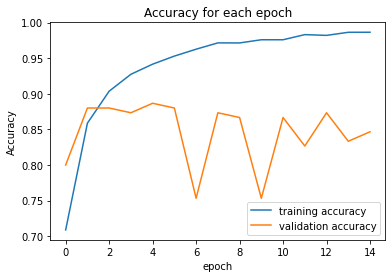

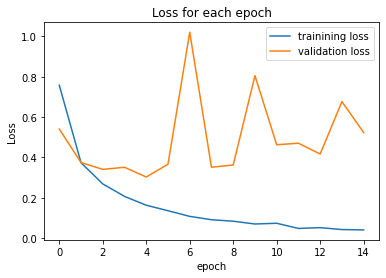

Instructions for updating:
Please use Model.evaluate, which supports generators.
Accuracy = 90.67%


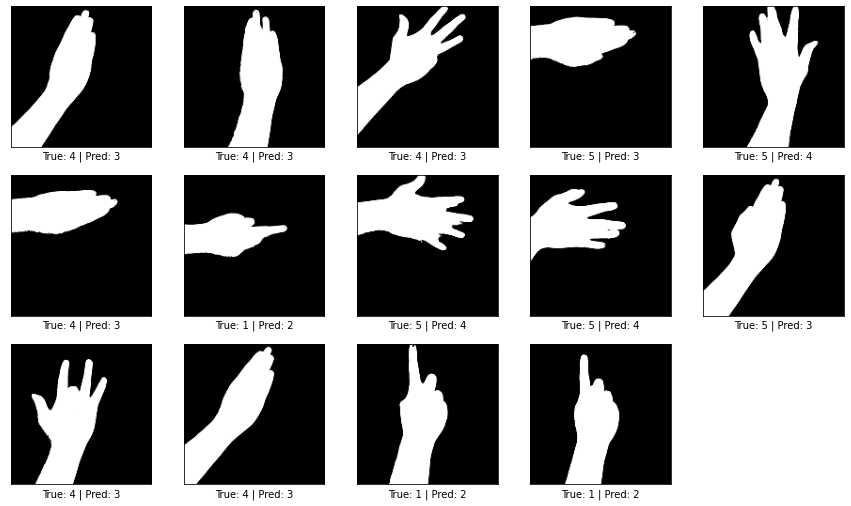

Error rate:  0.09333333333333334
Missed:  14 / 150


In [0]:
get_performance(model, history, test_image_generator)
generator_mismatched(model, test_image_generator, image_shape=(150, 150, 3), colorscale='colored')

In [0]:
# Save if scores beats 93.33% on validation set
model.save(root_path + 'VGG16.BestModel')
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              16779264  
_________________________________________________________________
dense_7 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 12294     
Total params: 35,702,598
Trainable params: 33,967,110
Non-trainable params: 1,735,488
_________________________________________________________________


### Best Result:
- Achieved from unfreezing the top two layers of VGG16 conv_base

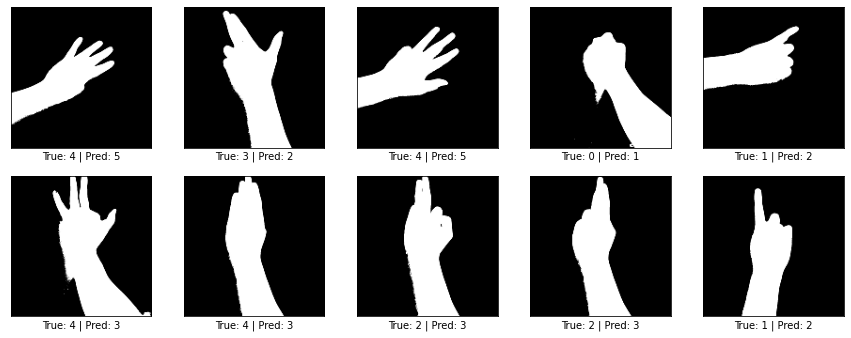

Error rate:  0.06666666666666667
Missed:  10 / 150


In [0]:
model.load_weights(root_path + 'VGG16.BestModel.hdf5')
generator_mismatched(model, validation_image_generator, image_shape=(150, 150, 3), colorscale='colored')

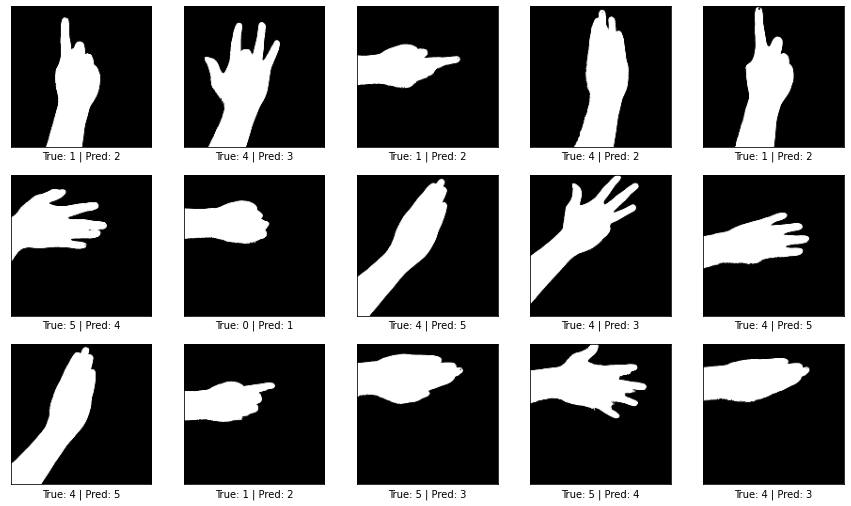

Error rate:  0.1
Missed:  15 / 150


In [0]:
# Get performance on test set
model.load_weights(root_path + 'VGG16.BestModel.hdf5')
generator_mismatched(model, test_image_generator, image_shape=(150, 150, 3), colorscale='colored')

## ResNet50

### Observe entire architecture:
- Mimick Dense layer "proportional" to our situation 

In [0]:
from tensorflow.keras.applications.resnet50 import ResNet50

# Import Resnet with weights learned from the imagenet dataset
conv_base = ResNet50(weights = 'imagenet')
conv_base.summary()

102973440/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

### Take convolutional base

In [0]:
from tensorflow.keras.applications.resnet50 import ResNet50

# Import Resnet with weights learned from the imagenet dataset
conv_base = ResNet50(weights = 'imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.summary()

94773248/94765736 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
__________________________

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import models

# Set all to trainable
conv_base.trainable = True

# Loop freezing all except the top convolution layer
set_trainable = False
for layer in conv_base.layers:
  # Determine when to start un freezing
  if layer.name == 'conv4_block1_1_conv':
    set_trainable = True

  if set_trainable:
    print(layer.name, '(is trainable)')
    layer.trainable = True
  else:
    print(layer.name, '(is not trainable)')
    layer.trainable = False

conv_base.summary()

input_2 (is not trainable)
conv1_pad (is not trainable)
conv1_conv (is not trainable)
conv1_bn (is not trainable)
conv1_relu (is not trainable)
pool1_pad (is not trainable)
pool1_pool (is not trainable)
conv2_block1_1_conv (is not trainable)
conv2_block1_1_bn (is not trainable)
conv2_block1_1_relu (is not trainable)
conv2_block1_2_conv (is not trainable)
conv2_block1_2_bn (is not trainable)
conv2_block1_2_relu (is not trainable)
conv2_block1_0_conv (is not trainable)
conv2_block1_3_conv (is not trainable)
conv2_block1_0_bn (is not trainable)
conv2_block1_3_bn (is not trainable)
conv2_block1_add (is not trainable)
conv2_block1_out (is not trainable)
conv2_block2_1_conv (is not trainable)
conv2_block2_1_bn (is not trainable)
conv2_block2_1_relu (is not trainable)
conv2_block2_2_conv (is not trainable)
conv2_block2_2_bn (is not trainable)
conv2_block2_2_relu (is not trainable)
conv2_block2_3_conv (is not trainable)
conv2_block2_3_bn (is not trainable)
conv2_block2_add (is not trainable)
c

In [0]:
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(6, activation='softmax'))

# Set an extremely low learning rate so we don't ruin the representations of all the trainable layers
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-5), 
              metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 12294     
Total params: 23,600,006
Trainable params: 22,096,902
Non-trainable params: 1,503,104
_________________________________________________________________


In [0]:
history = train_on_generator(
      model, training_image_generator,
      validation_image_generator, 
      best_model_filepath=root_path+'ResNet50.best_model.hdf5'  
      )

Epoch 1/100
100/100 - 179s - loss: 1.0989 - acc: 0.5697 - val_loss: 1.8409 - val_acc: 0.2200
Epoch 2/100
100/100 - 178s - loss: 0.5329 - acc: 0.7982 - val_loss: 0.8952 - val_acc: 0.6333
Epoch 3/100
100/100 - 177s - loss: 0.3621 - acc: 0.8684 - val_loss: 0.5379 - val_acc: 0.8000
Epoch 4/100
100/100 - 177s - loss: 0.2596 - acc: 0.9036 - val_loss: 0.4369 - val_acc: 0.8533
Epoch 5/100
100/100 - 176s - loss: 0.2246 - acc: 0.9171 - val_loss: 0.4666 - val_acc: 0.8533
Epoch 6/100
100/100 - 178s - loss: 0.1798 - acc: 0.9353 - val_loss: 0.4149 - val_acc: 0.8533
Epoch 7/100
100/100 - 179s - loss: 0.1599 - acc: 0.9435 - val_loss: 0.3981 - val_acc: 0.8733
Epoch 8/100
100/100 - 175s - loss: 0.1302 - acc: 0.9535 - val_loss: 0.3940 - val_acc: 0.8600
Epoch 9/100
100/100 - 173s - loss: 0.1166 - acc: 0.9581 - val_loss: 0.4050 - val_acc: 0.8733
Epoch 10/100
100/100 - 173s - loss: 0.1114 - acc: 0.9593 - val_loss: 0.4252 - val_acc: 0.8733
Epoch 11/100
100/100 - 176s - loss: 0.0917 - acc: 0.9671 - val_loss: 

In [0]:
model.load_weights(root_path + 'ResNet50.best_model.hdf5')

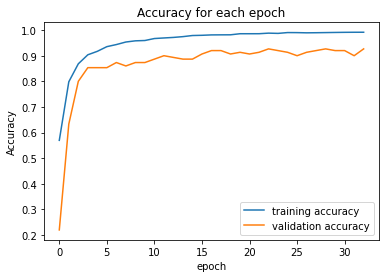

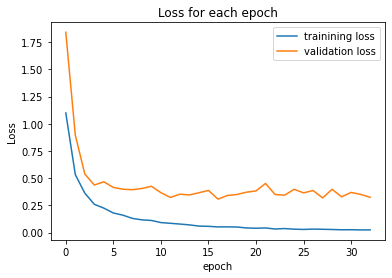

Accuracy = 92.00%


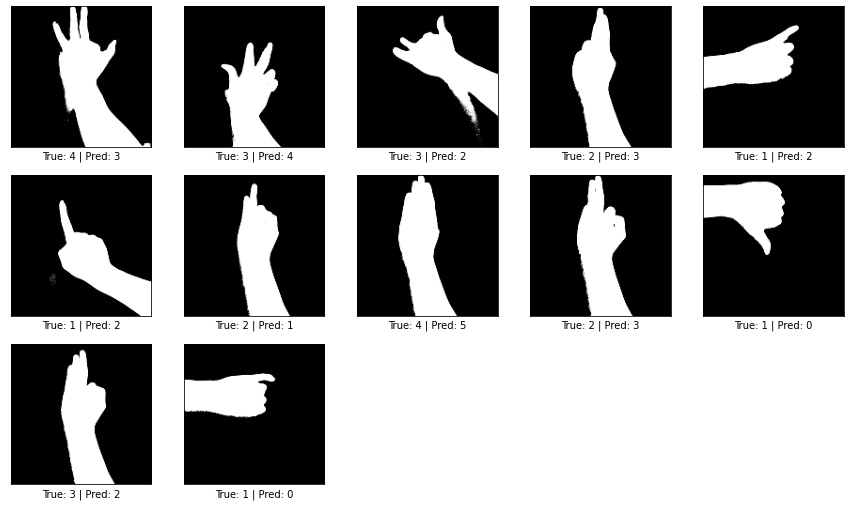

Error rate:  0.08
Missed:  12 / 150


In [0]:
get_performance(model, history, validation_image_generator)
generator_mismatched(model, validation_image_generator, image_shape=(150, 150, 3), colorscale='colored')

In [0]:
# Only run this if score is better than 92.67%
model.save_weights(root_path + 'ResNet50.BestModel.hdf5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 12294     
Total params: 23,600,006
Trainable params: 22,096,902
Non-trainable params: 1,503,104
_________________________________________________________________


### Best Result:
- Achieved from unfreezing top two layer of ResNet conv_base

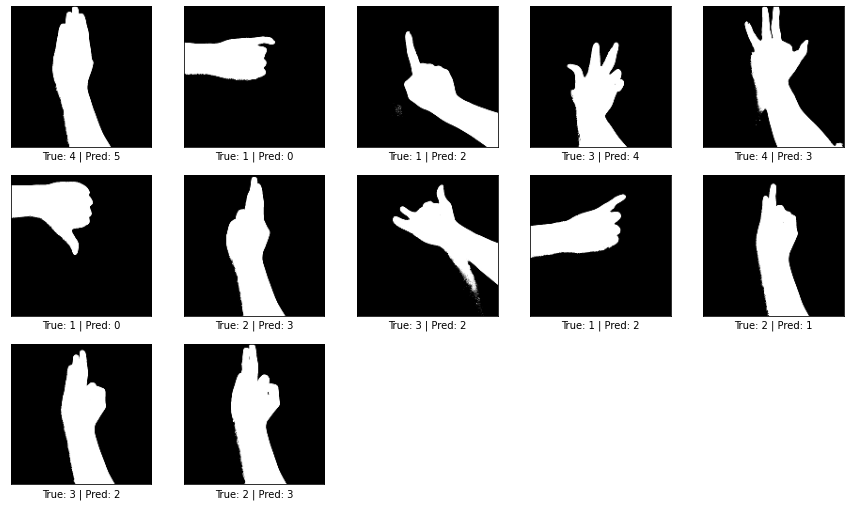

Error rate:  0.08
Missed:  12 / 150


In [0]:
model.load_weights(root_path + 'ResNet50.BestModel.hdf5')
generator_mismatched(model, validation_image_generator, image_shape=(150, 150, 3), colorscale='colored')

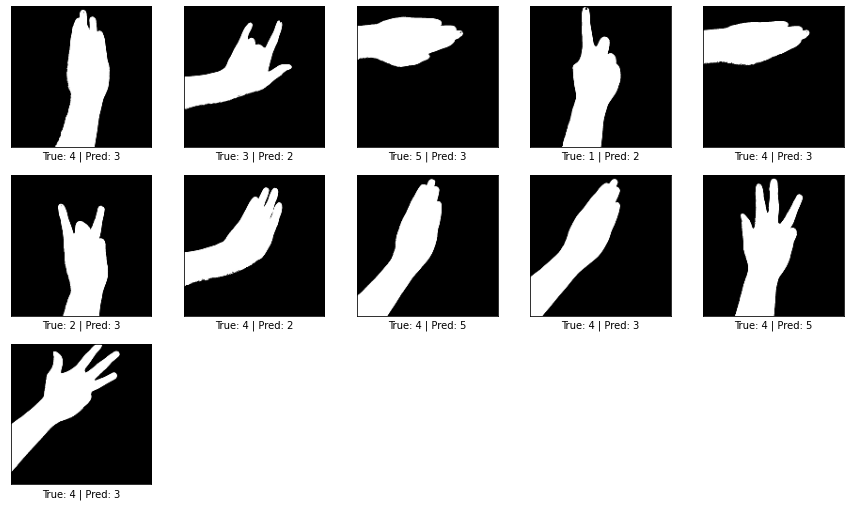

Error rate:  0.07333333333333333
Missed:  11 / 150


In [0]:
# Performance on test set
model.load_weights(root_path + 'ResNet50.BestModel.hdf5')
generator_mismatched(model, test_image_generator, image_shape=(150, 150, 3), colorscale='colored')

## Using InceptionV3


### Observe full architecture
- Mimick accordingly

In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Import Resnet with weights learned from the imagenet dataset
conv_base = InceptionV3(weights = 'imagenet')
conv_base.summary()


96116736/96112376 [==============================] - 2s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________

### Extract convolution base
- Mimick the original Dense layer

In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Import Resnet with weights learned from the imagenet dataset
conv_base = InceptionV3(weights = 'imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import models

# Set all to trainable
conv_base.trainable = True

# Loop freezing all except the top convolution layer
set_trainable = False
for layer in conv_base.layers:
  # Determine when to start un freezing
  if layer.name == 'conv2d_274':
    set_trainable = True

  if set_trainable:
    print(layer.name, '(is trainable)')
    layer.trainable = True
  else:
    print(layer.name, '(is not trainable)')
    layer.trainable = False

conv_base.summary()

input_2 (is not trainable)
conv2d_94 (is not trainable)
batch_normalization_94 (is not trainable)
activation_94 (is not trainable)
conv2d_95 (is not trainable)
batch_normalization_95 (is not trainable)
activation_95 (is not trainable)
conv2d_96 (is not trainable)
batch_normalization_96 (is not trainable)
activation_96 (is not trainable)
max_pooling2d_4 (is not trainable)
conv2d_97 (is not trainable)
batch_normalization_97 (is not trainable)
activation_97 (is not trainable)
conv2d_98 (is not trainable)
batch_normalization_98 (is not trainable)
activation_98 (is not trainable)
max_pooling2d_5 (is not trainable)
conv2d_102 (is not trainable)
batch_normalization_102 (is not trainable)
activation_102 (is not trainable)
conv2d_100 (is not trainable)
conv2d_103 (is not trainable)
batch_normalization_100 (is not trainable)
batch_normalization_103 (is not trainable)
activation_100 (is not trainable)
activation_103 (is not trainable)
average_pooling2d_9 (is not trainable)
conv2d_99 (is not train

In [0]:
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(6, activation='softmax'))

# Set an extremely low learning rate so we don't ruin the representations of all the trainable layers
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-5), 
              metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 21,815,078
Trainable params: 21,780,646
Non-trainable params: 34,432
_________________________________________________________________


In [0]:
history = train_on_generator(
      model, training_image_generator,
      validation_image_generator, 
      best_model_filepath=root_path+'InceptionV3.best_model.Reg-Drp50.hdf5'  
      )

Epoch 1/100
100/100 - 175s - loss: 1.1330 - acc: 0.5811 - val_loss: 1.0687 - val_acc: 0.5933
Epoch 2/100
100/100 - 174s - loss: 0.7082 - acc: 0.7413 - val_loss: 0.8591 - val_acc: 0.6600
Epoch 3/100
100/100 - 173s - loss: 0.5671 - acc: 0.7907 - val_loss: 0.8100 - val_acc: 0.6933
Epoch 4/100
100/100 - 174s - loss: 0.4923 - acc: 0.8201 - val_loss: 0.7755 - val_acc: 0.7067
Epoch 5/100
100/100 - 174s - loss: 0.4362 - acc: 0.8393 - val_loss: 0.7535 - val_acc: 0.7133
Epoch 6/100
100/100 - 173s - loss: 0.3930 - acc: 0.8557 - val_loss: 0.7206 - val_acc: 0.7200
Epoch 7/100
100/100 - 173s - loss: 0.3703 - acc: 0.8609 - val_loss: 0.7139 - val_acc: 0.7333
Epoch 8/100
100/100 - 171s - loss: 0.3417 - acc: 0.8752 - val_loss: 0.7245 - val_acc: 0.7267
Epoch 9/100
100/100 - 173s - loss: 0.3171 - acc: 0.8829 - val_loss: 0.7069 - val_acc: 0.7400
Epoch 10/100
100/100 - 174s - loss: 0.3064 - acc: 0.8867 - val_loss: 0.7043 - val_acc: 0.7333
Epoch 11/100
100/100 - 171s - loss: 0.2792 - acc: 0.8972 - val_loss: 

In [0]:
model.load_weights(root_path + 'InceptionV3.best_model.Reg-Drp50.hdf5')

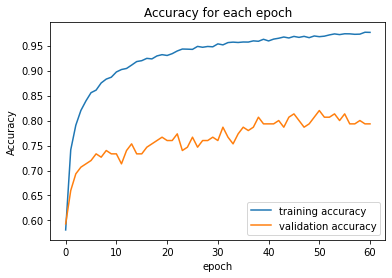

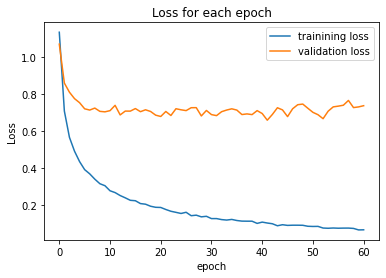

Accuracy = 79.33%


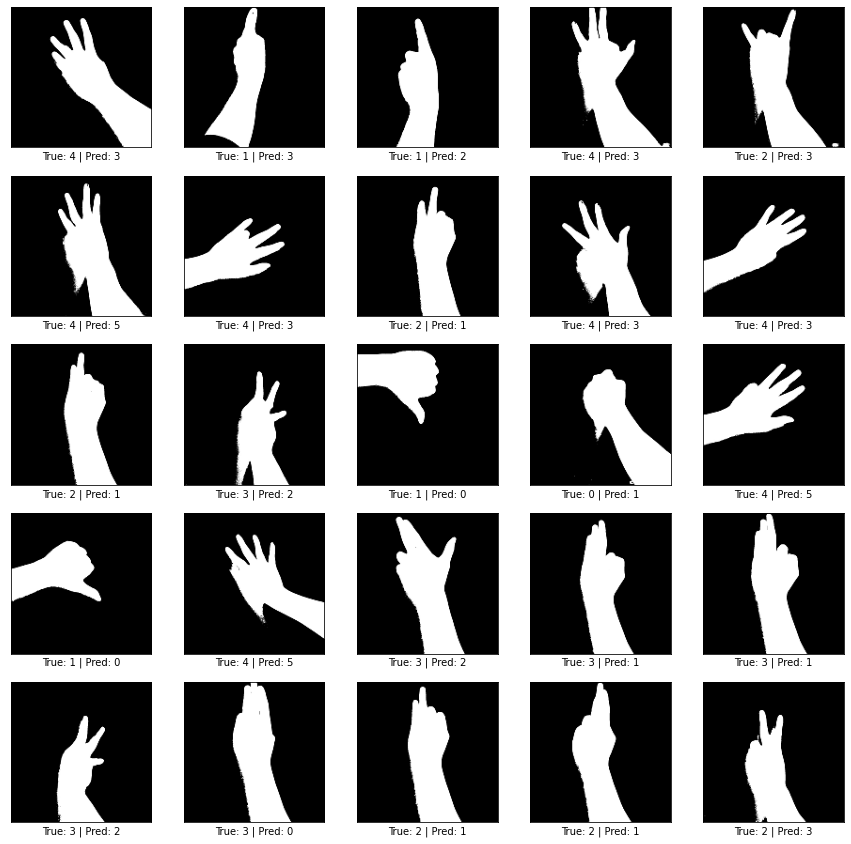

Error rate:  0.20666666666666667
Missed:  31 / 150


In [0]:
get_performance(model, history, validation_image_generator)
generator_mismatched(model, validation_image_generator, image_shape=(150, 150, 3), colorscale='colored')

In [0]:
# Only save weights if score is over 79.33%
model.save_weights(root_path + 'InceptionV3.BestModel.hdf5')

### Best Result:

- Top two layers of convolutional base is traineable

In [0]:
model.load_weights(root_path + 'InceptionV3.BestModel.hdf5')
generator_mismatched(model, validation_image_generator, image_shape=(150, 150, 3), colorscale='colored')

## DenseNet121

### Observe full architecture

In [0]:
from tensorflow.keras.applications.densenet import DenseNet121

# Import Resnet with weights learned from the imagenet dataset
conv_base = DenseNet121(weights = 'imagenet')
conv_base.summary()


33193984/33188688 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________

In [0]:
from tensorflow.keras.applications.densenet import DenseNet121

# Import Resnet with weights learned from the imagenet dataset
conv_base = DenseNet121(weights = 'imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 75, 75, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1/conv[0][0]                 
_______________________

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import models

# Set all to trainable
conv_base.trainable = True

# Loop freezing all except the top convolution layer
set_trainable = False
for layer in conv_base.layers:
  # Determine when to start un freezing
  if layer.name == 'conv4_block1_1_conv':
    set_trainable = True

  if set_trainable:
    print(layer.name, '(is trainable)')
    layer.trainable = True
  else:
    print(layer.name, '(is not trainable)')
    layer.trainable = False

conv_base.summary()

input_4 (is not trainable)
zero_padding2d (is not trainable)
conv1/conv (is not trainable)
conv1/bn (is not trainable)
conv1/relu (is not trainable)
zero_padding2d_1 (is not trainable)
pool1 (is not trainable)
conv2_block1_0_bn (is not trainable)
conv2_block1_0_relu (is not trainable)
conv2_block1_1_conv (is not trainable)
conv2_block1_1_bn (is not trainable)
conv2_block1_1_relu (is not trainable)
conv2_block1_2_conv (is not trainable)
conv2_block1_concat (is not trainable)
conv2_block2_0_bn (is not trainable)
conv2_block2_0_relu (is not trainable)
conv2_block2_1_conv (is not trainable)
conv2_block2_1_bn (is not trainable)
conv2_block2_1_relu (is not trainable)
conv2_block2_2_conv (is not trainable)
conv2_block2_concat (is not trainable)
conv2_block3_0_bn (is not trainable)
conv2_block3_0_relu (is not trainable)
conv2_block3_1_conv (is not trainable)
conv2_block3_1_bn (is not trainable)
conv2_block3_1_relu (is not trainable)
conv2_block3_2_conv (is not trainable)
conv2_block3_concat (i

In [0]:
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(6, activation='softmax'))

# Set an extremely low learning rate so we don't ruin the representations of all the trainable layers
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-5), 
              metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 4, 4, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 6150      
Total params: 7,043,654
Trainable params: 5,529,862
Non-trainable params: 1,513,792
_________________________________________________________________


In [0]:
history = train_on_generator(
      model, training_image_generator,
      validation_image_generator, 
      best_model_filepath=root_path+'DenseNet121.best_model.Reg-Drp50.hdf5'  
      )

Epoch 1/100
100/100 - 173s - loss: 1.2543 - acc: 0.5247 - val_loss: 1.3546 - val_acc: 0.5000
Epoch 2/100
100/100 - 174s - loss: 0.5447 - acc: 0.8018 - val_loss: 0.7503 - val_acc: 0.6933
Epoch 3/100
100/100 - 176s - loss: 0.3531 - acc: 0.8728 - val_loss: 0.5341 - val_acc: 0.7933
Epoch 4/100
100/100 - 174s - loss: 0.2669 - acc: 0.9077 - val_loss: 0.5000 - val_acc: 0.8000
Epoch 5/100
100/100 - 175s - loss: 0.2069 - acc: 0.9307 - val_loss: 0.4569 - val_acc: 0.8067
Epoch 6/100
100/100 - 177s - loss: 0.1708 - acc: 0.9420 - val_loss: 0.4164 - val_acc: 0.8333
Epoch 7/100
100/100 - 175s - loss: 0.1398 - acc: 0.9530 - val_loss: 0.4127 - val_acc: 0.8467
Epoch 8/100
100/100 - 173s - loss: 0.1198 - acc: 0.9610 - val_loss: 0.4264 - val_acc: 0.8467
Epoch 9/100
100/100 - 172s - loss: 0.0939 - acc: 0.9691 - val_loss: 0.4181 - val_acc: 0.8533
Epoch 10/100
100/100 - 173s - loss: 0.0875 - acc: 0.9723 - val_loss: 0.4235 - val_acc: 0.8533
Epoch 11/100
100/100 - 172s - loss: 0.0723 - acc: 0.9765 - val_loss: 

In [0]:
model.load_weights(root_path + 'DenseNet121.best_model.Reg-Drp50.hdf5')

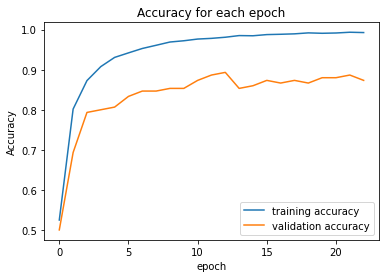

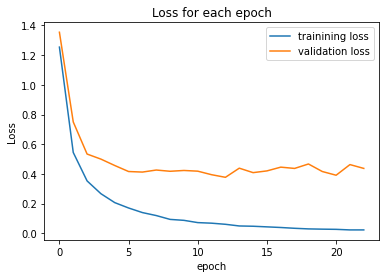

Accuracy = 89.33%


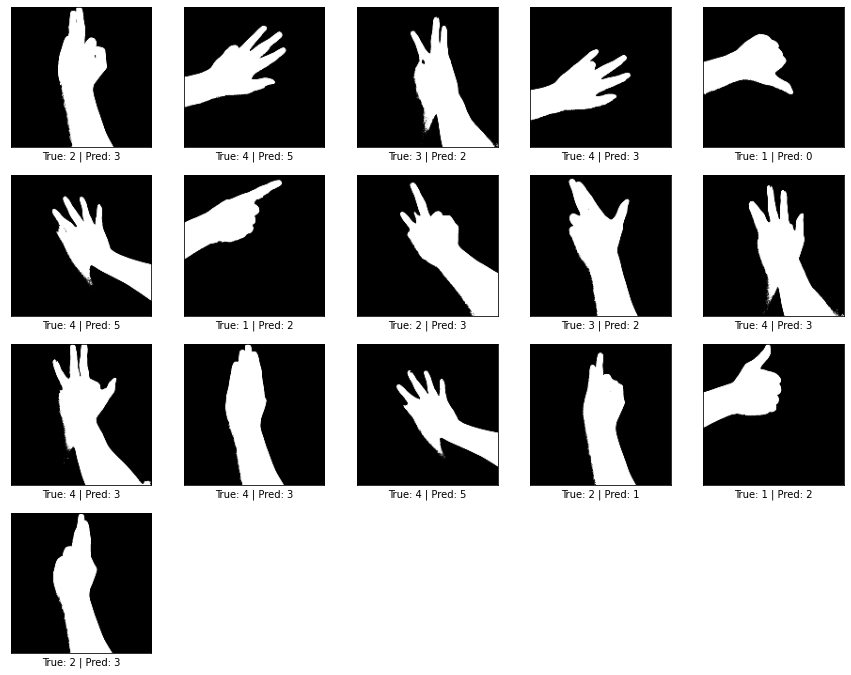

Error rate:  0.10666666666666667
Missed:  16 / 150


In [0]:
get_performance(model, history, validation_image_generator)
generator_mismatched(model, validation_image_generator, image_shape=(150, 150, 3), colorscale='colored')

In [0]:
# Save only when model score if higher than 89.33
model.save_weights(root_path + 'DenseNet121.BestModel.hdf5')

### Best Result:
- Top two layers of convolution base are made traineable

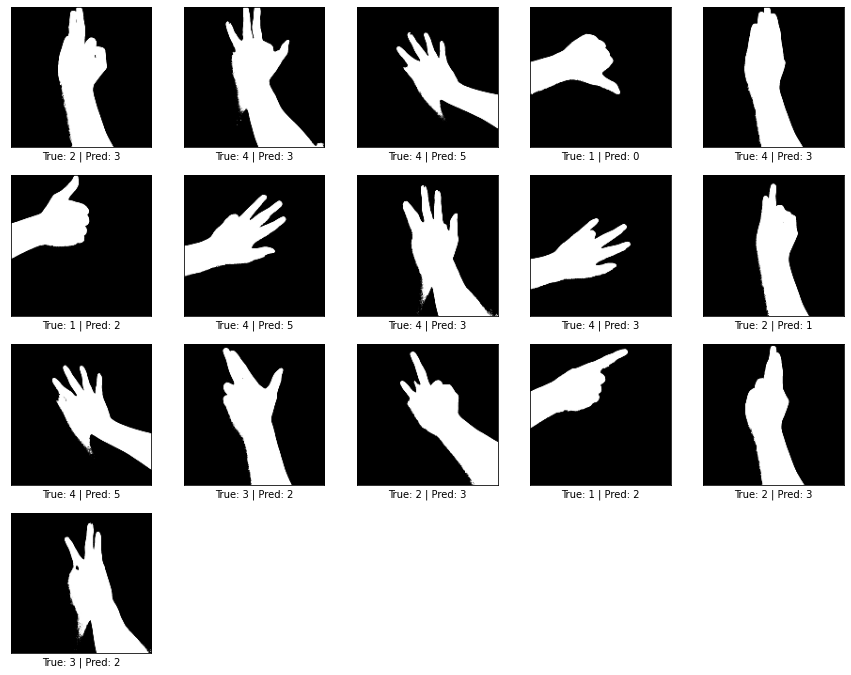

Error rate:  0.10666666666666667
Missed:  16 / 150


In [0]:
model.load_weights(root_path + 'DenseNet121.BestModel.hdf5')
generator_mismatched(model, validation_image_generator, image_shape=(150, 150, 3), colorscale='colored')

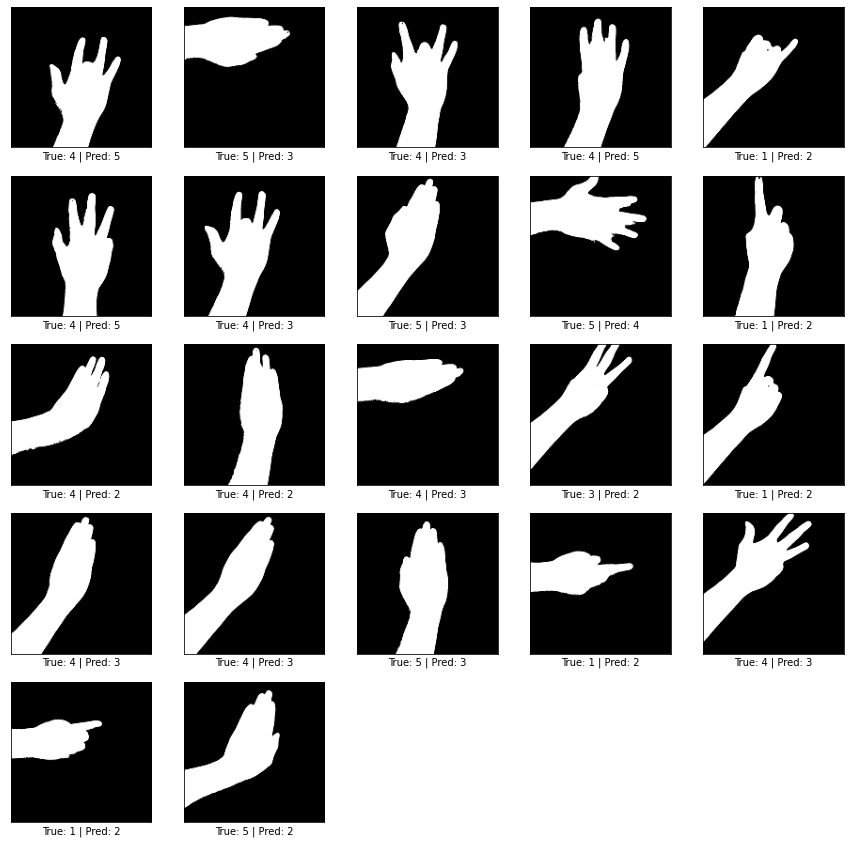

Error rate:  0.14666666666666667
Missed:  22 / 150


In [0]:

model.load_weights(root_path + 'DenseNet121.BestModel.hdf5')
generator_mismatched(model, test_image_generator, image_shape=(150, 150, 3), colorscale='colored')